<h2>Dataset Loading</h2>

In [1]:
# Importing necessary libraries for handling the data
import pandas as pd

# Loading the datasets provided
suicidewatch_posts = pd.read_csv('SuicideWatch_posts.csv')
depression_posts = pd.read_csv('depression_posts.csv')
depression_comments = pd.read_csv('depression_comments.csv')
suicidewatch_comments = pd.read_csv('SuicideWatch_comments.csv')


# Combining all posts datasets into a single DataFrame 'df_posts'
df_posts = pd.concat([suicidewatch_posts,depression_posts], ignore_index=True)

df_posts = df_posts.drop(columns=['Flair'])


# Combining all comments datasets into a single DataFrame 'df_comments'
df_comments = pd.concat([suicidewatch_comments,depression_comments], ignore_index=True)

# Displaying the structure of the combined datasets to confirm the merge
df_posts_shape = df_posts.shape
df_comments_shape = df_comments.shape

df_posts_head = df_posts.head()
df_comments_head = df_comments.head()

df_posts_shape, df_comments_shape, df_posts_head, df_comments_head


((10000, 8),
 (23042, 7),
                    User                                         Post Title  \
 0         gktqkbcnbr_jj           I just don’t care and want to end things   
 1        Sad_Cancel_705         I’ve decided to kill myself in 30 minutes    
 2           Thatmaa4986                      Suicidal at 34 weeks pregnant   
 3  Expensive_Flounder28  I finally figured out which way I'm going to k...   
 4  MalsAdaptiveDreaming  Thinking of jumping off a bridge above water. ...   
 
                                              Content  Score  Comments Count  \
 0                                                NaN      1               0   
 1  I 19m just wants someone to talk to before I d...      2               0   
 2  (28F) I am 34 weeks pregnant and struglling wi...      4               1   
 3  I'm going to wait until a very cold winter nig...      2               0   
 4  I wonder what the lethality is for 20-25 feet ...      1               0   
 
    Upvote Ratio

<h2>Data Preprocessing</h2>

https://www.mdpi.com/1660-4601/19/19/12635

This step aims to filter textual posts to eliminate noise before applying feature extraction and embedding techniques, and to produce a word vector for classification. It includes stop word removal, punctuation removal, lowercasing, tokenization, and lemmatization. We employed the Natural Language Toolkit (NLTK) [34] and performed basic tasks to preprocess the dataset.
Punctuation, emoji, and numerical digit removal: this process removes the characters “?, !, :, ;, ’,” and emoji to make the text easily processable.

<b>Stop word removal</b>: this process removes words such as “the”, “a”, “an”, and “in”, which have no contribution to the operation of the model.

<b>Lowercasing</b>: this process lowercases all words.

<b>Tokenization</b>: this process splits each sentence into its basic parts, such as words, phrases, and other pieces of information.

<b>Lemmatization</b>: this process combines inflected forms of words into their root form.


In [2]:
# Import required libraries
import re

from nltk.corpus import stopwords
import nltk
import spacy
# Download stopwords if not already available
#nltk.download('stopwords')
nlp = spacy.load("en_core_web_sm")
stop_words = set(stopwords.words('english'))

# Define a comprehensive data cleaning function
def preprocess_text(text, remove_stopwords=True, convert_emojis=False):
    # Convert non-string entries to an empty string
    if not isinstance(text, str):
        text = ""
    # Remove URLs, emails, newline symbols, and HTML tags
    text = re.sub(r'http\S+|www.\S+|\b\w+@\w+\.\w+\b|<.*?>', '', text)
    # Remove special characters and punctuation
    text = re.sub(r'[^A-Za-z0-9\s]', '', text)
    # Optionally handle emojis
    if convert_emojis:
        text = re.sub(r'[\U0001F600-\U0001F64F]', '[EMOJI]', text)  # Converts emojis to [EMOJI] label
    else:
        text = re.sub(r'[\U0001F600-\U0001F64F]', '', text)  # Removes emojis
    # Convert to lowercase
    text = text.lower()
    # Process text with SpaCy and optionally remove stopwords
    doc = nlp(text)
    if remove_stopwords:
        return ' '.join([token.lemma_ for token in doc if token.text not in stop_words])
    else:
        return ' '.join([token.lemma_ for token in doc])

# Apply this cleaning function to text columns in your datasets
df_posts['Content'] = df_posts['Content'].apply(lambda x: preprocess_text(x, remove_stopwords=True, convert_emojis=False))
df_comments['Comment Body'] = df_comments['Comment Body'].apply(lambda x: preprocess_text(x, remove_stopwords=True, convert_emojis=False))


<h3>Tokenization</h3>

In [3]:
# Importing necessary libraries for tokenization
import nltk
from nltk.tokenize import word_tokenize, sent_tokenize
import spacy

# Downloading NLTK resources if not already available
#nltk.download('punkt')
#nltk.download('punkt_tab')
# Loading SpaCy model
nlp = spacy.load("en_core_web_sm")

# Define a function to perform tokenization
def tokenize_text(text, level='word', method='spacy'):
    """
    Tokenizes text based on specified level and method.

    Parameters:
    - text (str): Input text to be tokenized.
    - level (str): 'word' for word-level tokenization or 'sentence' for sentence-level tokenization.
    - method (str): 'spacy' for SpaCy tokenization, 'nltk' for NLTK tokenization.

    Returns:
    - list: List of tokens at the specified level.
    """
    if not isinstance(text, str):
        return []  # Return empty list if text is not a valid string
    
    if method == 'spacy':
        doc = nlp(text)
        if level == 'word':
            tokens = [token.text for token in doc]
        elif level == 'sentence':
            tokens = [sent.text for sent in doc.sents]
    elif method == 'nltk':
        if level == 'word':
            tokens = word_tokenize(text)
        elif level == 'sentence':
            tokens = sent_tokenize(text)
    
    return tokens

# Applying tokenization on 'Content' in posts and 'Comment Body' in comments

# For posts - SpaCy word-level and sentence-level tokenization
df_posts['SpaCy_Word_Tokens'] = df_posts['Content'].apply(lambda x: tokenize_text(x, level='word', method='spacy'))
df_posts['SpaCy_Sentence_Tokens'] = df_posts['Content'].apply(lambda x: tokenize_text(x, level='sentence', method='spacy'))

# For comments - NLTK word-level and sentence-level tokenization
df_comments['NLTK_Word_Tokens'] = df_comments['Comment Body'].apply(lambda x: tokenize_text(x, level='word', method='nltk'))
df_comments['NLTK_Sentence_Tokens'] = df_comments['Comment Body'].apply(lambda x: tokenize_text(x, level='sentence', method='nltk'))


<h3>lemmatization</h3>

In [4]:
# Import necessary libraries
import re
import spacy
from nltk.stem import PorterStemmer
from textblob import TextBlob
import contractions  # Import contractions module

# Load SpaCy model for lemmatization
nlp = spacy.load("en_core_web_sm")

# Initialize Porter Stemmer for stemming if needed
stemmer = PorterStemmer()

# Define preprocessing function
def preprocess_text(text, lemmatize=True, use_stemming=False, correct_spelling=False, expand_contractions=True):
    """
    Cleans and preprocesses text by lemmatizing or stemming, with optional spell correction and contraction expansion.
    
    Parameters:
    - text (str): The text to be processed.
    - lemmatize (bool): Whether to apply lemmatization (default is True).
    - use_stemming (bool): Whether to apply stemming (default is False).
    - correct_spelling (bool): Whether to perform spell correction (default is False).
    - expand_contractions (bool): Whether to expand contractions (default is True).
    
    Returns:
    - str: The processed text.
    """
    # Expand contractions if specified
    if expand_contractions:
        text = contractions.fix(text)

    # Convert text to lowercase
    text = text.lower()

    # Spell correction (optional)
    if correct_spelling:
        text = str(TextBlob(text).correct())

    # Tokenize and apply lemmatization or stemming
    processed_tokens = []
    if lemmatize:
        # Lemmatization using SpaCy
        doc = nlp(text)
        processed_tokens = [token.lemma_ for token in doc]
    elif use_stemming:
        # Stemming using NLTK
        words = text.split()
        processed_tokens = [stemmer.stem(word) for word in words]
    else:
        # If neither lemmatization nor stemming, just split the text
        processed_tokens = text.split()

    # Join tokens back into a single string
    return ' '.join(processed_tokens)

# Example usage: Concatenate title and body, apply preprocessing
df_posts['Processed_Text'] = df_posts.apply(
    lambda row: preprocess_text(f"{row['Post Title']} {row['Content']}", 
                                lemmatize=True, 
                                correct_spelling=False, 
                                expand_contractions=True),
    axis=1
)

<h2>Data Exploration</h2>

https://onlinelibrary.wiley.com/doi/full/10.1155/2018/6157249

To understand suicidal individuals, we analysed the words, languages, and topics in online user content.

<h4>WordCloud</h4>


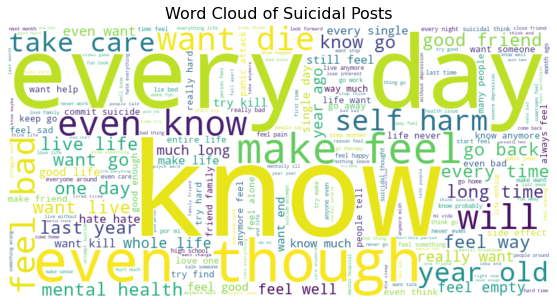

In [5]:
# Importing necessary libraries
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Combine all processed text from posts into one large string
all_text = ' '.join(df_posts['Processed_Text'])

# Generate the WordCloud
wordcloud = WordCloud(
    width=800,
    height=400,
    background_color='white',
    colormap='viridis',
    max_words=200
).generate(all_text)

# Display the WordCloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Suicidal Posts', fontsize=16)
plt.show()

<h3>LDA</h3>

In [6]:
# Importing necessary libraries
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

# Define the number of topics
num_topics = 10

# Create a CountVectorizer to transform text into a bag-of-words representation
vectorizer = CountVectorizer(max_df=0.9, min_df=10, stop_words='english')
dtm = vectorizer.fit_transform(df_posts['Processed_Text'])

# Perform Latent Dirichlet Allocation (LDA)
lda_model = LatentDirichletAllocation(n_components=num_topics, random_state=42)
lda_model.fit(dtm)

# Extract the top words for each topic
def get_top_words(model, feature_names, n_top_words=10):
    topics = {}
    for topic_idx, topic in enumerate(model.components_):
        top_features_ind = topic.argsort()[:-n_top_words - 1:-1]
        top_features = [feature_names[i] for i in top_features_ind]
        topics[topic_idx + 1] = top_features
    return topics

# Get the feature names and extract topics
feature_names = vectorizer.get_feature_names_out()
topics = get_top_words(lda_model, feature_names)

# Display the topics
for topic, words in topics.items():
    print(f"Topic {topic}: {', '.join(words)}")

Topic 1: feel, want, like, life, know, make, really, live, people, year
Topic 2: life, feel, know, like, bad, people, hate, think, time, live
Topic 3: feel, like, time, think, work, want, make, know, pain, try
Topic 4: feel, know, like, talk, want, think, people, help, really, suicide
Topic 5: que, mi, por, la, lo, eh, feel, dad, vida, es
Topic 6: feel, like, know, bad, year, think, leave, tell, time, make
Topic 7: feel, like, want, know, life, love, try, hate, good, way
Topic 8: school, feel, day, hate, think, love, work, like, people, year
Topic 9: want, life, anymore, day, like, fuck, die, wish, know, time
Topic 10: feel, like, friend, know, talk, day, think, want, really, thing


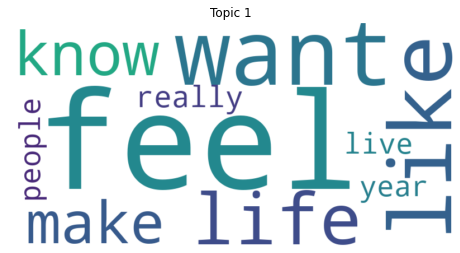

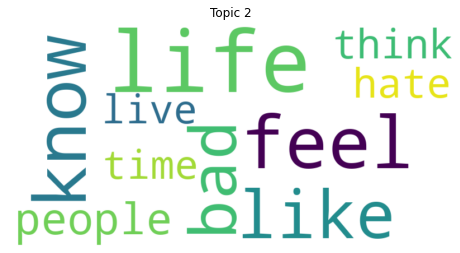

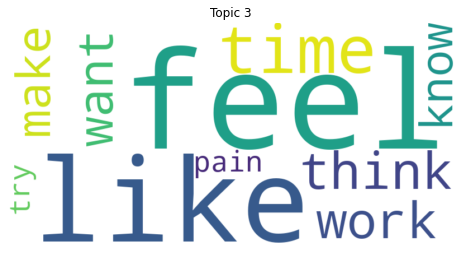

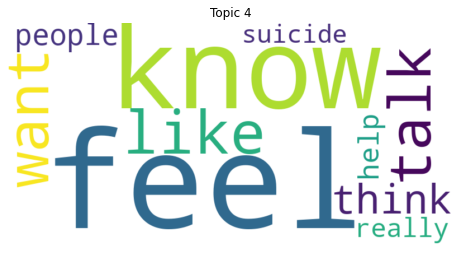

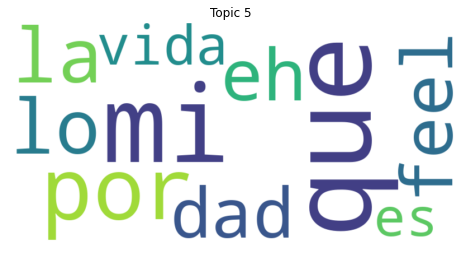

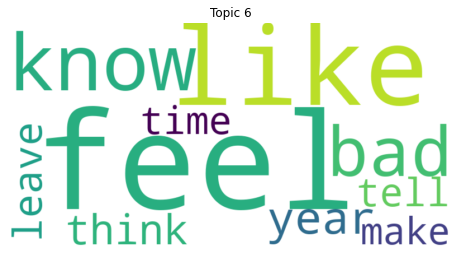

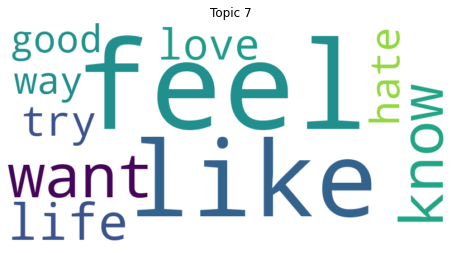

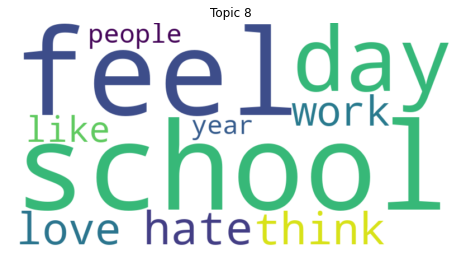

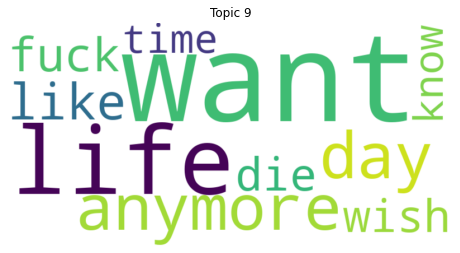

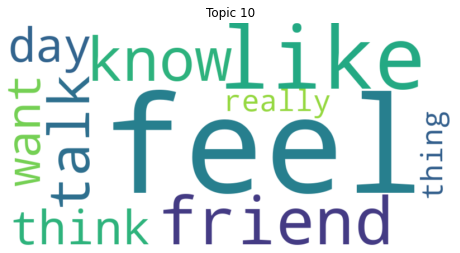

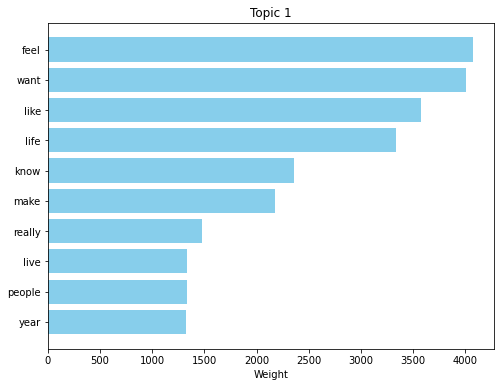

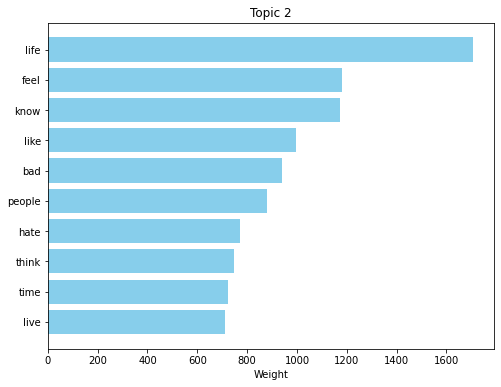

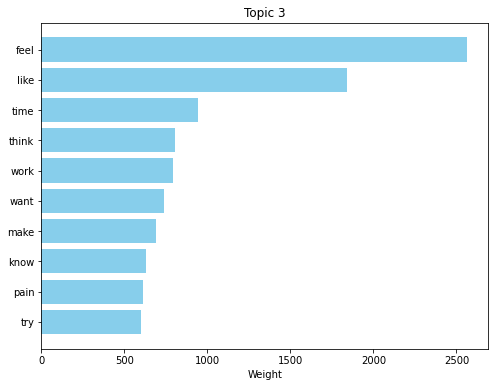

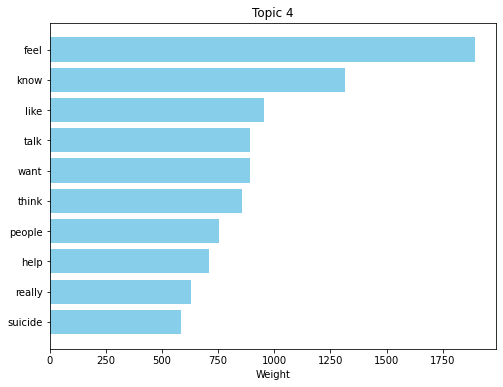

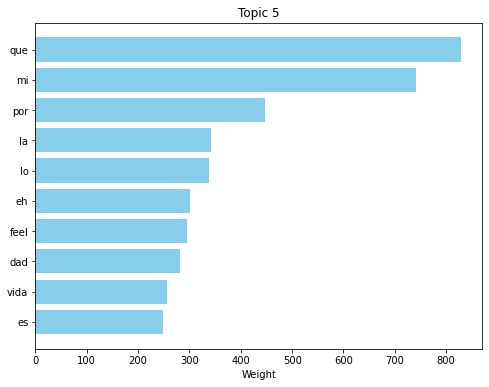

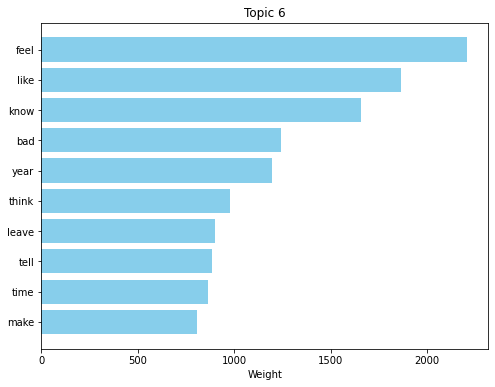

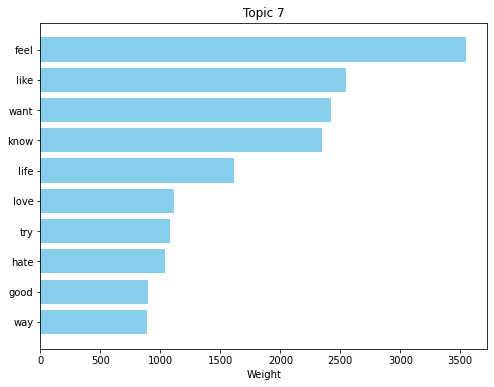

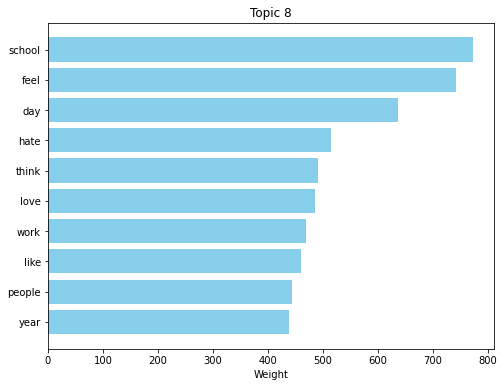

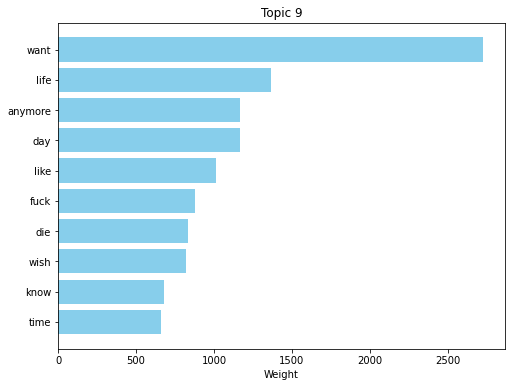

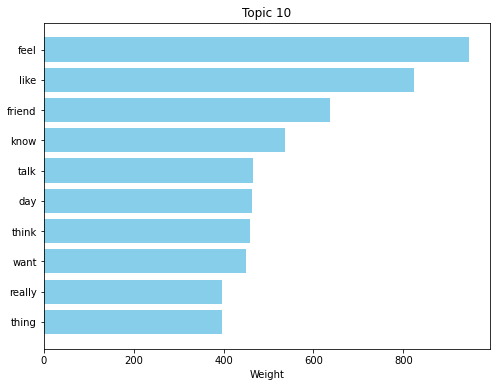

In [7]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import numpy as np

# Function to visualize topics as word clouds
def plot_lda_topics_as_wordcloud(model, feature_names, num_topics, num_top_words=10):
    for topic_idx, topic in enumerate(model.components_):
        # Get the top words for each topic
        top_features_ind = topic.argsort()[:-num_top_words - 1:-1]
        top_words = [feature_names[i] for i in top_features_ind]
        top_weights = topic[top_features_ind]
        
        # Create a dictionary for word cloud
        wordcloud_data = dict(zip(top_words, top_weights))
        
        # Create a word cloud for the current topic
        plt.figure(figsize=(8, 6))
        plt.title(f'Topic {topic_idx + 1}')
        wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(wordcloud_data)
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.axis('off')
        plt.show()

# Function to plot bar charts for the top words in each topic
def plot_lda_topics_as_barchart(model, feature_names, num_topics, num_top_words=10):
    for topic_idx, topic in enumerate(model.components_):
        # Get the top words for each topic
        top_features_ind = topic.argsort()[:-num_top_words - 1:-1]
        top_words = [feature_names[i] for i in top_features_ind]
        top_weights = topic[top_features_ind]
        
        # Create a bar plot for top words
        plt.figure(figsize=(8, 6))
        plt.barh(top_words, top_weights, color='skyblue')
        plt.xlabel('Weight')
        plt.title(f'Topic {topic_idx + 1}')
        plt.gca().invert_yaxis()  # Invert y-axis to have the highest weight at the top
        plt.show()

# Visualize the topics using WordCloud
plot_lda_topics_as_wordcloud(lda_model, feature_names, num_topics)

# Visualize the topics using Bar Chart
plot_lda_topics_as_barchart(lda_model, feature_names, num_topics)


In [8]:
# Import the LIWC categories
from liwc_categories import liwc_categories

# Function to calculate LIWC-like statistics
def calculate_liwc_stats(texts, categories):
    stats = {key: 0 for key in categories.keys()}
    total_words = 0

    for text in texts:
        words = word_tokenize(text.lower())
        total_words += len(words)
        
        for category, words_list in categories.items():
            stats[category] += sum(1 for word in words if word in words_list)
    
    # Convert counts to average per text
    for key in stats.keys():
        stats[key] /= len(texts)
    
    stats["average_word_count"] = total_words / len(texts)
    return stats

# Analyze your dataset
texts = df_posts['Processed_Text']  # Assuming this column contains cleaned text
liwc_stats = calculate_liwc_stats(texts, liwc_categories)

# Display the results
import pandas as pd
liwc_stats_df = pd.DataFrame([liwc_stats])
print(liwc_stats_df)



   personal_pronouns  quantifiers  positive_emotion  negative_emotion  \
0             4.6004       1.5328            0.9958            1.1716   

   anxiety   death  swear_words  family  friend  female_references  \
0   0.2717  1.0641        0.385  1.5103  0.6636             0.5634   

   male_references    work  money  past_focus  present_focus  future_focus  \
0           0.4409  0.7714    0.4      0.1368        15.0255        2.7059   

   average_word_count  
0             95.8159  


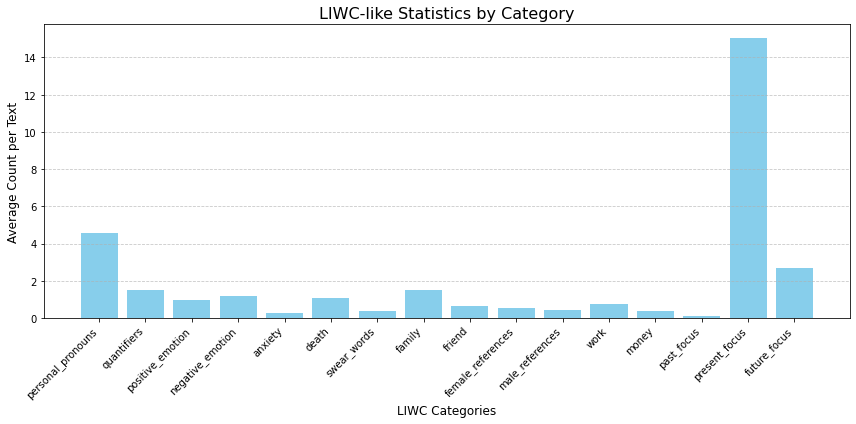

In [9]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming liwc_stats is already calculated as a dictionary
# Exclude 'average_word_count' for category-based visualization
if "average_word_count" in liwc_stats:
    categories = {key: value for key, value in liwc_stats.items() if key != "average_word_count"}
else:
    categories = liwc_stats

# Convert the dictionary to a DataFrame for easier visualization
categories_df = pd.DataFrame(list(categories.items()), columns=["Category", "Average Count"])

# Visualization as a bar chart
plt.figure(figsize=(12, 6))
plt.bar(categories_df["Category"], categories_df["Average Count"], color="skyblue")
plt.xticks(rotation=45, ha="right", fontsize=10)
plt.xlabel("LIWC Categories", fontsize=12)
plt.ylabel("Average Count per Text", fontsize=12)
plt.title("LIWC-like Statistics by Category", fontsize=16)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()

# Display the plot
plt.show()


<h2>Adding labels to datasets</h2>

<h4>Posts label</h4>

In [10]:
from transformers import pipeline, AutoTokenizer, AutoModelForSequenceClassification
import pandas as pd
import torch

# Check if GPU is available and select it (if possible)
device = 0 if torch.cuda.is_available() else -1  # 0 for GPU, -1 for CPU

# Load TinyBERT fine-tuned for sentiment analysis (available in Hugging Face model hub)
model_name = 'huawei-noah/TinyBERT_General_4L_312D'
sentiment_analyzer = pipeline('sentiment-analysis', 
                              model=model_name, 
                              device=device)  # Use GPU if available

# Define function to classify Risk_Level based on sentiment
def classify_risk_level(text):
    # Tokenize and truncate the input to a maximum length of 512 tokens
    sentiment = sentiment_analyzer(text[:512])[0]  # Ensure we don't pass longer text
    sentiment_label = sentiment['label']
    sentiment_score = sentiment['score']

    if sentiment_label == 'NEGATIVE' and sentiment_score >= 0.85:
        return 'High'
    elif sentiment_label == 'NEGATIVE' and sentiment_score > 0.6:
        return 'Moderate'
    else:
        return 'Low'

# Sample DataFrame
# # Replace with your actual DataFrame loading
# data = {'Processed_Text': ['This is bad!', 'I love this!', 'It could be better.']}
# df_posts = pd.DataFrame(data)

# Apply the function to classify Risk_Level
df_posts['Risk_Level'] = df_posts['Processed_Text'].apply(classify_risk_level)

# Display the results
print(df_posts)


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at huawei-noah/TinyBERT_General_4L_312D and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/iss

                      User                                         Post Title  \
0            gktqkbcnbr_jj           I just don’t care and want to end things   
1           Sad_Cancel_705         I’ve decided to kill myself in 30 minutes    
2              Thatmaa4986                      Suicidal at 34 weeks pregnant   
3     Expensive_Flounder28  I finally figured out which way I'm going to k...   
4     MalsAdaptiveDreaming  Thinking of jumping off a bridge above water. ...   
...                    ...                                                ...   
9995              Peace_Un  Feel like a failure. Starting to think about t...   
9996            Static0722  I need help I can't stop arguing with people a...   
9997         whiskeybent99                                        Job search    
9998      GeneralMudkip101                                How do I disappear?   
9999   Cultural_Formal9350           I could really use some advice right now   

                           

In [11]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

# Initialize VADER
analyzer = SentimentIntensityAnalyzer()

# Define a function to classify Risk_Level
def classify_risk_level(text):
    sentiment_score = analyzer.polarity_scores(text)['compound']
    if sentiment_score <= -0.85:  # Strongly negative
        return 'High'
    elif -0.6 < sentiment_score <= -0.2:  # Moderately negative
        return 'Moderate'
    else:  # Neutral or positive
        return 'Low'

# Apply to the dataset
df_posts['Risk_Level'] = df_posts['Processed_Text'].apply(classify_risk_level)


/var/folders/68/zwqn0ws14_l2cr8xg5jd23gw0000gn/T/ipykernel_11423/3319806549.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df_posts, x='Risk_Level', palette='coolwarm')


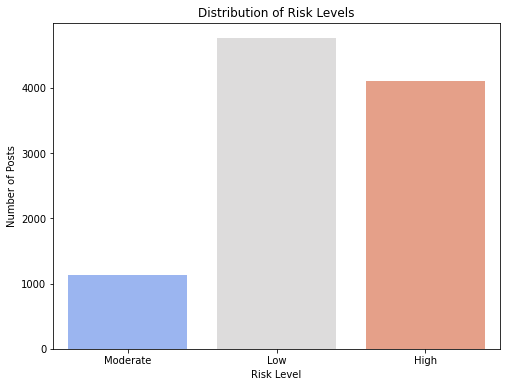

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt

# Plotting the distribution of the Risk_Level column
plt.figure(figsize=(8, 6))
sns.countplot(data=df_posts, x='Risk_Level', palette='coolwarm')
plt.title('Distribution of Risk Levels')
plt.xlabel('Risk Level')
plt.ylabel('Number of Posts')
plt.show()


<h3>Analysis of Risk Level</h3>

https://www.sciencedirect.com/science/article/pii/S1319157821003244

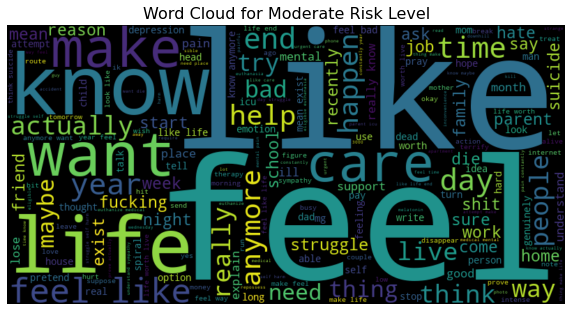

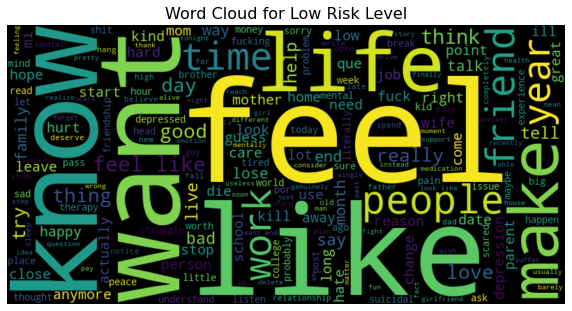

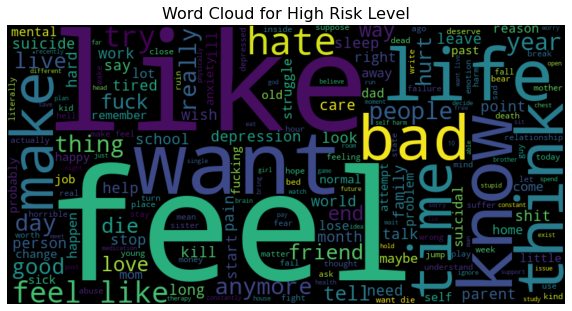

In [13]:
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer
from nltk.util import ngrams
from collections import Counter

# Load your dataset (ensure `df_posts` contains 'Processed_Text' and 'Risk_Level')
df_posts['Risk_Level'] = df_posts['Risk_Level'].fillna('No Risk')  # Handle missing labels

# Define a function to extract n-grams
def extract_ngrams(texts, n=1):
    vectorizer = CountVectorizer(ngram_range=(n, n), stop_words='english')
    ngram_counts = vectorizer.fit_transform(texts)
    ngram_features = vectorizer.get_feature_names_out()
    ngram_frequencies = ngram_counts.toarray().sum(axis=0)
    return dict(zip(ngram_features, ngram_frequencies))

# Generate word clouds for each risk level
risk_levels = df_posts['Risk_Level'].unique()

# Mapping numerical risk levels to their names
risk_level_mapping = {0: "Low", 1: "Moderate", 2: "High"}

for risk_level in risk_levels:
    # Filter the posts for the specific risk level
    texts = df_posts[df_posts['Risk_Level'] == risk_level]['Processed_Text'].dropna()
    
    # Extract n-grams
    unigram_counts = extract_ngrams(texts, n=1)
    bigram_counts = extract_ngrams(texts, n=2)
    trigram_counts = extract_ngrams(texts, n=3)
    
    # Combine all n-grams into a single dictionary
    combined_counts = Counter(unigram_counts) + Counter(bigram_counts) + Counter(trigram_counts)
    
    # Get the top 300 n-grams
    top_ngrams = dict(combined_counts.most_common(300))
    
    # Generate word cloud
    wordcloud = WordCloud(width=800, height=400, background_color='black').generate_from_frequencies(top_ngrams)
    
    # Plot the word cloud
    plt.figure(figsize=(10, 6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(f'Word Cloud for {risk_level} Risk Level', fontsize=16)
    plt.axis('off')
    plt.show()

<h4>Comments empathy label</h4>

In [14]:
# Define a function to classify Empathy_Level
def classify_empathy_level(text):
    sentiment_score = analyzer.polarity_scores(text)['compound']
    if sentiment_score > 0.5:  # Strongly positive
        return 'High'
    elif -0.2 <= sentiment_score <= 0.5:  # Neutral to slightly positive
        return 'Neutral'
    else:  # Negative sentiment
        return 'Low'

# Apply to the comments dataset
df_comments['Empathy_Level'] = df_comments['Comment Body'].apply(classify_empathy_level)


/var/folders/68/zwqn0ws14_l2cr8xg5jd23gw0000gn/T/ipykernel_11423/1428913615.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df_comments, x='Empathy_Level', palette='coolwarm')


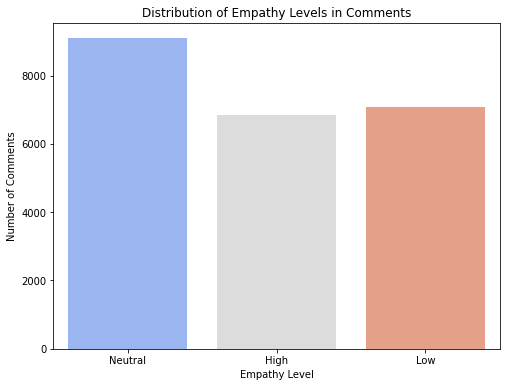

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt

# Plotting the distribution of the Empathy_Level column
plt.figure(figsize=(8, 6))
sns.countplot(data=df_comments, x='Empathy_Level', palette='coolwarm')
plt.title('Distribution of Empathy Levels in Comments')
plt.xlabel('Empathy Level')
plt.ylabel('Number of Comments')
plt.show()


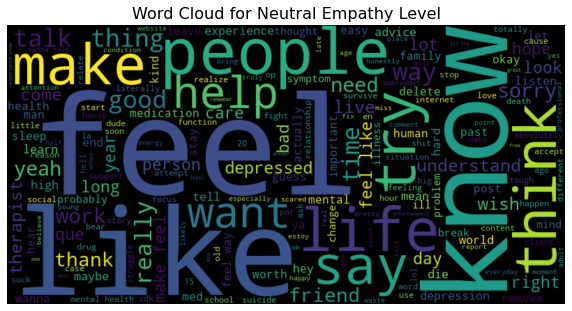

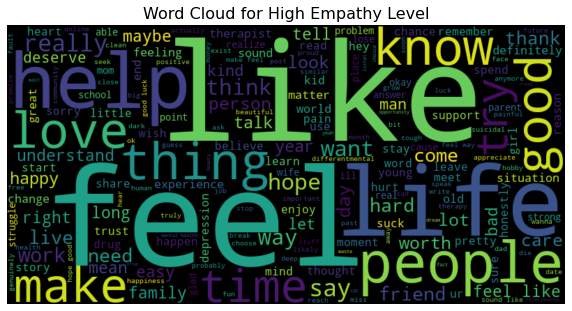

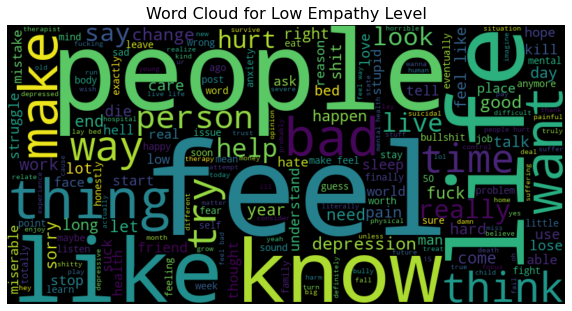

In [16]:
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer
from nltk.util import ngrams
from collections import Counter

# Ensure 'Empathy_Level' column is filled appropriately
df_comments['Empathy_Level'] = df_comments['Empathy_Level'].fillna('No Empathy')  # Handle missing labels

# Define a function to extract n-grams
def extract_ngrams(texts, n=1):
    vectorizer = CountVectorizer(ngram_range=(n, n), stop_words='english')
    ngram_counts = vectorizer.fit_transform(texts)
    ngram_features = vectorizer.get_feature_names_out()
    ngram_frequencies = ngram_counts.toarray().sum(axis=0)
    return dict(zip(ngram_features, ngram_frequencies))

# Generate word clouds for each empathy level
empathy_levels = df_comments['Empathy_Level'].unique()

for empathy_level in empathy_levels:
    # Filter the comments for the specific empathy level
    texts = df_comments[df_comments['Empathy_Level'] == empathy_level]['Comment Body'].dropna()
    
    # Extract n-grams
    unigram_counts = extract_ngrams(texts, n=1)
    bigram_counts = extract_ngrams(texts, n=2)
    trigram_counts = extract_ngrams(texts, n=3)
    
    # Combine all n-grams into a single dictionary
    combined_counts = Counter(unigram_counts) + Counter(bigram_counts) + Counter(trigram_counts)
    
    # Get the top 300 n-grams
    top_ngrams = dict(combined_counts.most_common(300))
    
    # Generate word cloud
    wordcloud = WordCloud(width=800, height=400, background_color='black').generate_from_frequencies(top_ngrams)
    
    # Plot the word cloud
    plt.figure(figsize=(10, 6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(f'Word Cloud for {empathy_level} Empathy Level', fontsize=16)
    plt.axis('off')
    plt.show()

<h2>Word Embedding+feature engineering</h2>

https://www.mdpi.com/1660-4601/19/19/12635

<h4>TF-IDF + word2Vec </h4>

https://onlinelibrary.wiley.com/doi/full/10.1155/2018/6157249

statistical features +topic features

https://ieeexplore.ieee.org/stamp/stamp.jsp?arnumber=10666498

ngram features

https://www.mdpi.com/1660-4601/19/19/12635

LIWC features



In [17]:
import pandas as pd
import numpy as np
import nltk
from nltk.tokenize import word_tokenize, sent_tokenize

# Download required NLTK data files
nltk.download('punkt')

# Function to compute the statistical features
def compute_text_statistics(title, body):
    # Title statistics
    title_words = word_tokenize(title)
    title_tokens = len(title_words)
    title_chars = len(title)
    title_word_count = len([word for word in title_words if word.isalpha()])

    # Body statistics
    body_words = word_tokenize(body)
    body_tokens = len(body_words)
    body_chars = len(body)
    body_word_count = len([word for word in body_words if word.isalpha()])
    body_sentences = len(sent_tokenize(body))
    body_paragraphs = len(body.split('\n'))  # Assuming paragraphs are separated by new lines

    return {
        'Title_Word_Count': title_word_count,
        'Title_Token_Count': title_tokens,
        'Title_Char_Count': title_chars,
        'Body_Word_Count': body_word_count,
        'Body_Token_Count': body_tokens,
        'Body_Char_Count': body_chars,
        'Body_Sentence_Count': body_sentences,
        'Body_Paragraph_Count': body_paragraphs
    }

# Apply the function to each post and store the results in new columns
df_posts[['Title_Word_Count', 'Title_Token_Count', 'Title_Char_Count',
          'Body_Word_Count', 'Body_Token_Count', 'Body_Char_Count',
          'Body_Sentence_Count', 'Body_Paragraph_Count']] = df_posts.apply(
    lambda row: pd.Series(compute_text_statistics(row['Post Title'], row['Processed_Text'])), axis=1)


[nltk_data] Downloading package punkt to
[nltk_data]     /Users/rakibabdullah/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [18]:
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer

# Step 1: Use CountVectorizer to create a term-document matrix
count_vectorizer = CountVectorizer(max_df=0.9, min_df=10, stop_words='english')
dtm = count_vectorizer.fit_transform(df_posts['Processed_Text'])

# Step 2: Apply LDA to extract topics
num_topics = 10  # You can choose the number of topics based on your analysis
lda = LatentDirichletAllocation(n_components=num_topics, random_state=42)
lda_topics = lda.fit_transform(dtm)  # This will give us the topic probabilities for each post

# lda_topics will be a matrix of shape (n_posts, n_topics)
# Each row corresponds to a post, and each column represents the probability of the post belonging to a particular topic


In [19]:
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np
from gensim.models import Word2Vec
from sklearn.feature_extraction.text import CountVectorizer

# Step 1: Generate TF-IDF features
tfidf_vectorizer = TfidfVectorizer(max_df=0.9, min_df=10, stop_words='english')
tfidf_matrix = tfidf_vectorizer.fit_transform(df_posts['Processed_Text'])

# Step 2: Train Word2Vec model or load a pre-trained model
word2vec_model = Word2Vec(sentences=[text.split() for text in df_posts['Processed_Text']], vector_size=100, window=5, min_count=1, workers=4)

# Function to get Word2Vec embeddings for a document (average word vectors)
def get_word2vec_embedding(text, model):
    words = text.split()
    word_vectors = [model.wv[word] for word in words if word in model.wv]
    return np.mean(word_vectors, axis=0) if word_vectors else np.zeros(model.vector_size)

# Apply Word2Vec embeddings
word2vec_embeddings = df_posts['Processed_Text'].apply(lambda x: get_word2vec_embedding(x, word2vec_model))

# Step 3: Combine TF-IDF and Word2Vec features
# Convert word2vec embeddings to an array
word2vec_matrix = np.array(word2vec_embeddings.tolist())

# Step 3: Combine TF-IDF, Word2Vec, and Statistical features

# Extract statistical features into a numpy array
statistical_features = df_posts[['Title_Word_Count', 'Title_Token_Count', 'Title_Char_Count',
                                 'Body_Word_Count', 'Body_Token_Count', 'Body_Char_Count',
                                 'Body_Sentence_Count', 'Body_Paragraph_Count']].values

# The topic features (lda_topics) are the probability distributions over the topics for each post
#topic_features = lda_model

# Step 5: N-gram features (specifically trigrams)
# ngram_vectorizer = CountVectorizer(ngram_range=(3, 3), stop_words='english')  # We are using only trigrams here
# ngram_matrix = ngram_vectorizer.fit_transform(df_posts['Processed_Text'])


# Now concatenate TF-IDF, Word2Vec, and statistical features
# Combine all features: TF-IDF, Word2Vec, Statistical, and Topic features,ngram features
combined_features = np.hstack([tfidf_matrix.toarray(), word2vec_matrix, statistical_features,lda_topics])

# You can now use the combined_features for further machine learning tasks


<h3>LIWC featuers</h3>

https://www.mdpi.com/1660-4601/19/19/12635


In [20]:
from liwc_categories import liwc_categories  # Assuming you have a file/module with LIWC categories

from nltk.tokenize import word_tokenize

def calculate_liwc_features(text, categories):
    """
    Calculate LIWC-like features for a single text.
    
    Parameters:
    - text (str): The text to process.
    - categories (dict): Dictionary of LIWC categories and their associated words.
    
    Returns:
    - dict: A dictionary with counts for each LIWC category.
    """
    liwc_counts = {category: 0 for category in categories.keys()}
    words = word_tokenize(text.lower())  # Tokenize and lowercase the text

    # Count occurrences for each LIWC category
    for category, words_list in categories.items():
        liwc_counts[category] = sum(1 for word in words if word in words_list)

    # Normalize counts by the number of words in the text
    total_words = len(words)
    if total_words > 0:
        liwc_counts = {key: value / total_words for key, value in liwc_counts.items()}
    else:
        liwc_counts = {key: 0 for key in liwc_counts.keys()}

    return liwc_counts

# Apply LIWC feature calculation to each post
liwc_features = df_posts['Processed_Text'].apply(lambda x: calculate_liwc_features(x, liwc_categories))

# Convert the list of LIWC features (dicts) into a DataFrame
liwc_features_df = pd.DataFrame(liwc_features.tolist())

# Concatenate the LIWC features to the original posts DataFrame
df_posts = pd.concat([df_posts, liwc_features_df], axis=1)

# Apply LIWC feature calculation to each post
liwc_features = df_posts['Processed_Text'].apply(lambda x: calculate_liwc_features(x, liwc_categories))

# Convert the list of LIWC features (dicts) into a DataFrame
liwc_features_df = pd.DataFrame(liwc_features.tolist())

# Concatenate the LIWC features to the original posts DataFrame
df_posts = pd.concat([df_posts, liwc_features_df], axis=1)

# Extract LIWC features into a numpy array
liwc_features_array = df_posts[liwc_features_df.columns].values

# Combine LIWC features with other feature matrices (e.g., TF-IDF, Word2Vec, etc.)
combined_features = np.hstack([tfidf_matrix.toarray(), word2vec_matrix, statistical_features, lda_topics, liwc_features_array])

/var/folders/68/zwqn0ws14_l2cr8xg5jd23gw0000gn/T/ipykernel_11423/3300007264.py:81: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=liwc_means_suicidal.values, y=liwc_means_suicidal.index, palette='viridis')


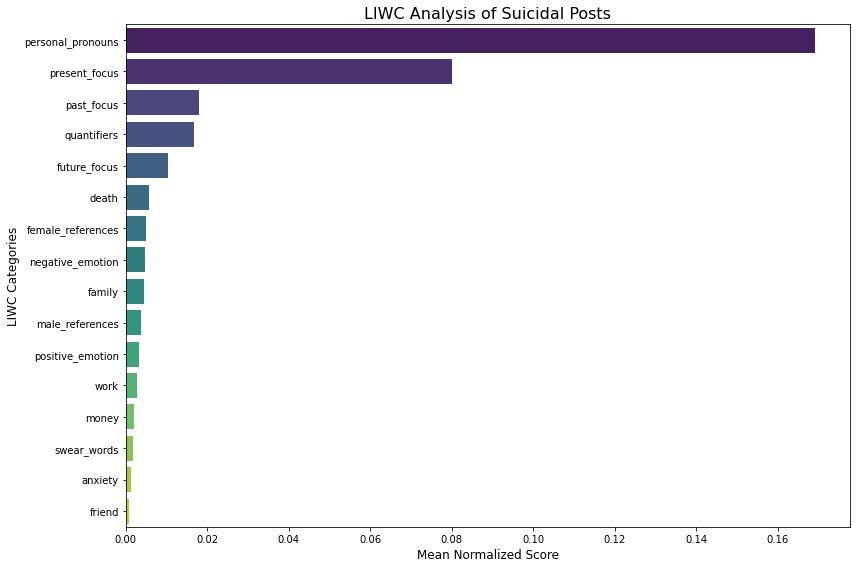

/var/folders/68/zwqn0ws14_l2cr8xg5jd23gw0000gn/T/ipykernel_11423/3300007264.py:91: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=liwc_means_non_suicidal.values, y=liwc_means_non_suicidal.index, palette='viridis')


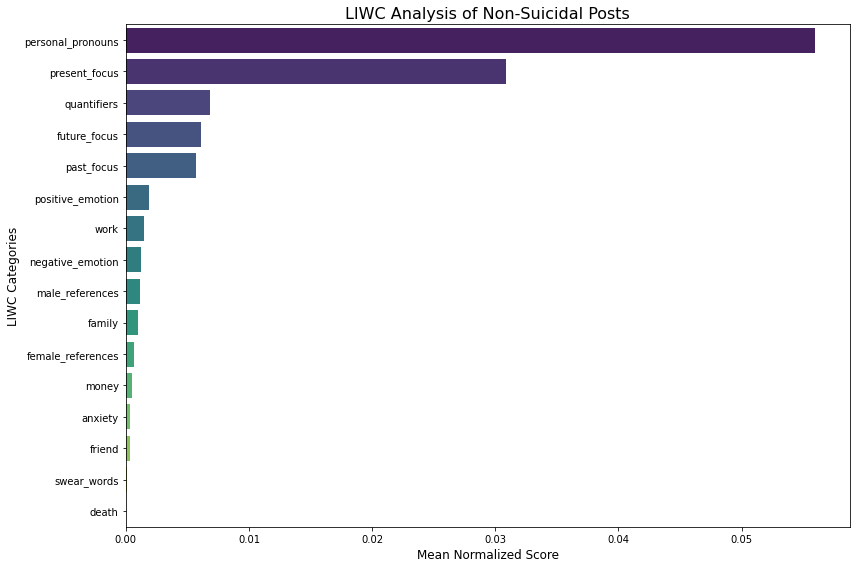

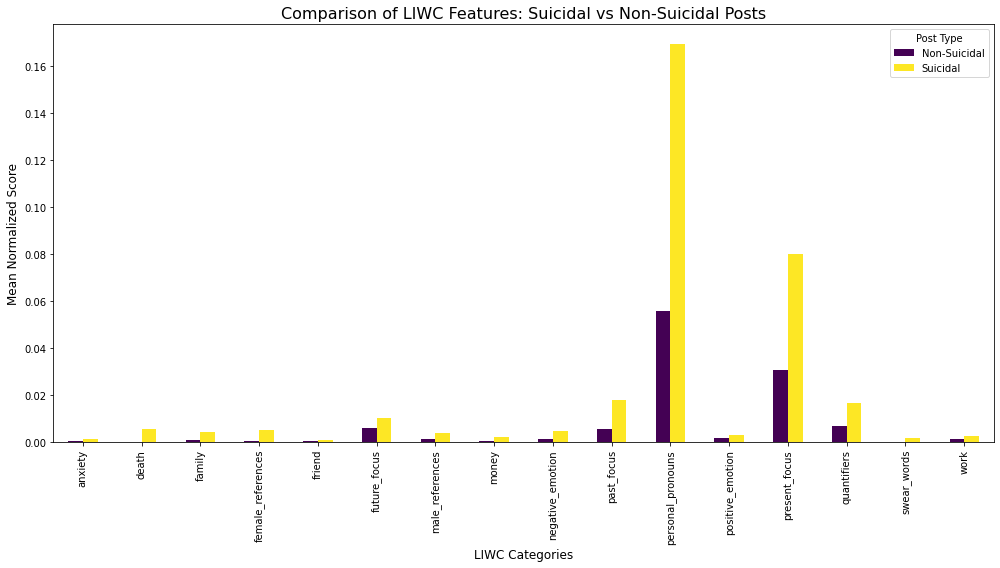

In [21]:
# Import necessary libraries
import pandas as pd
from nltk.tokenize import word_tokenize
import matplotlib.pyplot as plt
import seaborn as sns

# Load the datasets
suicidewatch_posts = pd.read_csv('SuicideWatch_posts.csv')
depression_posts = pd.read_csv('depression_posts.csv')
askreddit_posts = pd.read_csv('AskReddit_posts.csv')
getmotivated_posts = pd.read_csv('GetMotivated_posts.csv')

# Combine suicidal posts into a single DataFrame
suicidal_posts_df = pd.concat([suicidewatch_posts, depression_posts], ignore_index=True)

# Combine non-suicidal posts into a single DataFrame
non_suicidal_posts_df = pd.concat([askreddit_posts, getmotivated_posts], ignore_index=True)

# Ensure necessary columns are present
suicidal_posts_df['Processed_Text'] = suicidal_posts_df['Content'].fillna('')  # Replace NaN with empty string
non_suicidal_posts_df['Processed_Text'] = non_suicidal_posts_df['Content'].fillna('')  # Replace NaN with empty string

# Load LIWC categories
from liwc_categories import liwc_categories  # Assuming this module has LIWC categories

# Define a function to calculate LIWC features
def calculate_liwc_features(text, categories):
    """
    Calculate LIWC-like features for a single text.
    
    Parameters:
    - text (str): The text to process.
    - categories (dict): Dictionary of LIWC categories and their associated words.
    
    Returns:
    - dict: A dictionary with counts for each LIWC category.
    """
    liwc_counts = {category: 0 for category in categories.keys()}
    words = word_tokenize(text.lower())  # Tokenize and lowercase the text

    # Count occurrences for each LIWC category
    for category, words_list in categories.items():
        liwc_counts[category] = sum(1 for word in words if word in words_list)

    # Normalize counts by the number of words in the text
    total_words = len(words)
    if total_words > 0:
        liwc_counts = {key: value / total_words for key, value in liwc_counts.items()}
    else:
        liwc_counts = {key: 0 for key in liwc_counts.keys()}

    return liwc_counts

# Ensure all text is processed as strings
suicidal_posts_df['Processed_Text'] = suicidal_posts_df['Processed_Text'].astype(str)
non_suicidal_posts_df['Processed_Text'] = non_suicidal_posts_df['Processed_Text'].astype(str)

# Apply LIWC analysis to suicidal and non-suicidal posts
liwc_features_suicidal = suicidal_posts_df['Processed_Text'].apply(
    lambda x: calculate_liwc_features(x, liwc_categories)
)
liwc_features_non_suicidal = non_suicidal_posts_df['Processed_Text'].apply(
    lambda x: calculate_liwc_features(x, liwc_categories)
)

# Convert LIWC features to DataFrames
liwc_features_df_suicidal = pd.DataFrame(liwc_features_suicidal.tolist())
liwc_features_df_non_suicidal = pd.DataFrame(liwc_features_non_suicidal.tolist())

# Combine LIWC features with the original DataFrames
suicidal_posts_df = pd.concat([suicidal_posts_df, liwc_features_df_suicidal], axis=1)
non_suicidal_posts_df = pd.concat([non_suicidal_posts_df, liwc_features_df_non_suicidal], axis=1)

# Perform statistical analysis (mean values of LIWC features for visualization)
liwc_means_suicidal = liwc_features_df_suicidal.mean().sort_values(ascending=False)
liwc_means_non_suicidal = liwc_features_df_non_suicidal.mean().sort_values(ascending=False)


# Plot the LIWC features for suicidal posts
plt.figure(figsize=(12, 8))
sns.barplot(x=liwc_means_suicidal.values, y=liwc_means_suicidal.index, palette='viridis')
plt.title('LIWC Analysis of Suicidal Posts', fontsize=16)
plt.xlabel('Mean Normalized Score', fontsize=12)
plt.ylabel('LIWC Categories', fontsize=12)
plt.tight_layout()
plt.show()


# Plot the LIWC features for non-suicidal posts
plt.figure(figsize=(12, 8))
sns.barplot(x=liwc_means_non_suicidal.values, y=liwc_means_non_suicidal.index, palette='viridis')
plt.title('LIWC Analysis of Non-Suicidal Posts', fontsize=16)
plt.xlabel('Mean Normalized Score', fontsize=12)
plt.ylabel('LIWC Categories', fontsize=12)
plt.tight_layout()
plt.show()

# Comparison: Suicidal vs Non-Suicidal LIWC Features
# Combine the means for comparison
liwc_comparison = pd.DataFrame({
    'Non-Suicidal': liwc_means_non_suicidal,
    'Suicidal': liwc_means_suicidal
})

# Plot the comparison
liwc_comparison.plot(kind='bar', figsize=(14, 8), colormap='viridis')
plt.title('Comparison of LIWC Features: Suicidal vs Non-Suicidal Posts', fontsize=16)
plt.xlabel('LIWC Categories', fontsize=12)
plt.ylabel('Mean Normalized Score', fontsize=12)
plt.legend(title='Post Type', loc='upper right')
plt.tight_layout()
plt.show()

<h3>Feature Visualization using PCA</h3>

https://onlinelibrary.wiley.com/doi/full/10.1155/2018/6157249

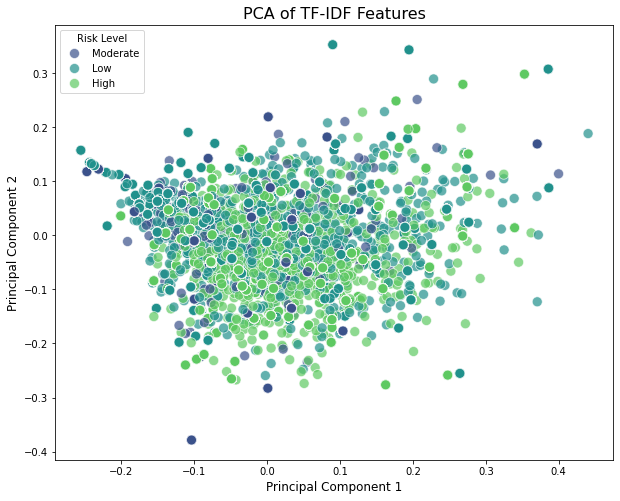

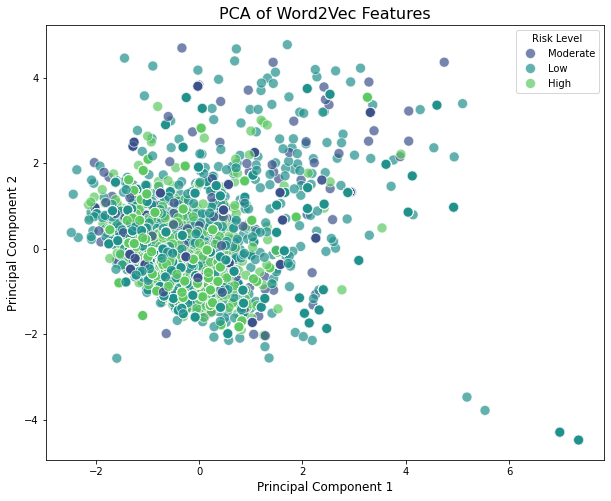

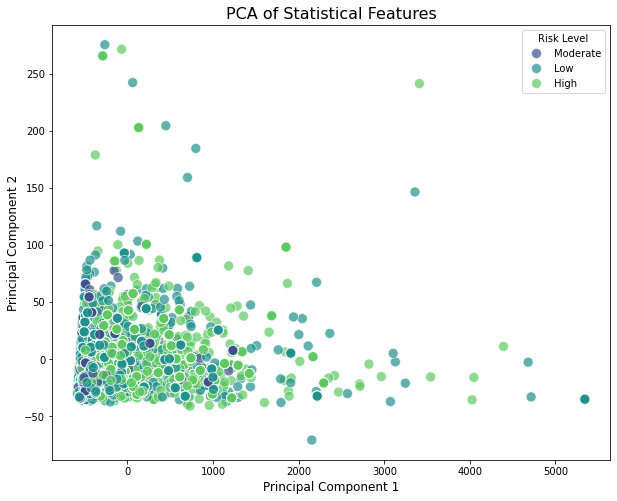

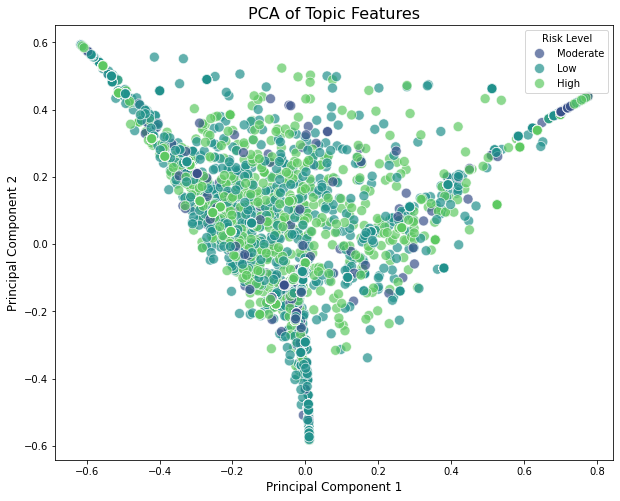

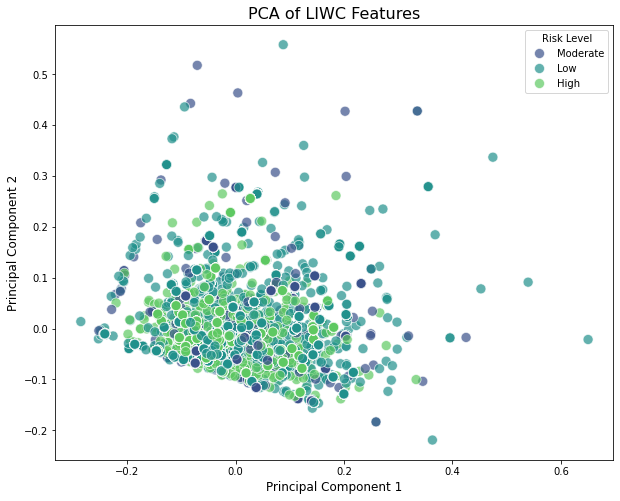

In [22]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import seaborn as sns
import pandas as pd

# Step 1: Apply PCA for each feature set separately

# 1. PCA for TF-IDF features
pca_tfidf = PCA(n_components=2)
reduced_tfidf = pca_tfidf.fit_transform(tfidf_matrix.toarray())

# 2. PCA for Word2Vec features
pca_word2vec = PCA(n_components=2)
reduced_word2vec = pca_word2vec.fit_transform(word2vec_matrix)

# 3. PCA for Statistical features
pca_statistical = PCA(n_components=2)
reduced_statistical = pca_statistical.fit_transform(statistical_features)

# 4. PCA for Topic features (LDA topics)
pca_topics = PCA(n_components=2)
reduced_topics = pca_topics.fit_transform(lda_topics)

# 5. PCA for N-gram features (trigrams)
# pca_ngram = PCA(n_components=2)
# reduced_ngram = pca_ngram.fit_transform(ngram_matrix.toarray())

# Step 2: Create DataFrames for easier visualization
df_tfidf = pd.DataFrame(reduced_tfidf, columns=['PCA1', 'PCA2'])
df_tfidf['Risk_Level'] = df_posts['Risk_Level']

df_word2vec = pd.DataFrame(reduced_word2vec, columns=['PCA1', 'PCA2'])
df_word2vec['Risk_Level'] = df_posts['Risk_Level']

df_statistical = pd.DataFrame(reduced_statistical, columns=['PCA1', 'PCA2'])
df_statistical['Risk_Level'] = df_posts['Risk_Level']

df_topics = pd.DataFrame(reduced_topics, columns=['PCA1', 'PCA2'])
df_topics['Risk_Level'] = df_posts['Risk_Level']

# df_ngram = pd.DataFrame(reduced_ngram, columns=['PCA1', 'PCA2'])
# df_ngram['Risk_Level'] = df_posts['Risk_Level']

# Step 3: Visualize each feature set separately

# Plot for TF-IDF features
plt.figure(figsize=(10, 8))
sns.scatterplot(x='PCA1', y='PCA2', hue='Risk_Level', data=df_tfidf, palette='viridis', s=100, alpha=0.7)
plt.title('PCA of TF-IDF Features', fontsize=16)
plt.xlabel('Principal Component 1', fontsize=12)
plt.ylabel('Principal Component 2', fontsize=12)
plt.legend(title='Risk Level', loc='best')
plt.show()

# Plot for Word2Vec features
plt.figure(figsize=(10, 8))
sns.scatterplot(x='PCA1', y='PCA2', hue='Risk_Level', data=df_word2vec, palette='viridis', s=100, alpha=0.7)
plt.title('PCA of Word2Vec Features', fontsize=16)
plt.xlabel('Principal Component 1', fontsize=12)
plt.ylabel('Principal Component 2', fontsize=12)
plt.legend(title='Risk Level', loc='best')
plt.show()

# Plot for Statistical features
plt.figure(figsize=(10, 8))
sns.scatterplot(x='PCA1', y='PCA2', hue='Risk_Level', data=df_statistical, palette='viridis', s=100, alpha=0.7)
plt.title('PCA of Statistical Features', fontsize=16)
plt.xlabel('Principal Component 1', fontsize=12)
plt.ylabel('Principal Component 2', fontsize=12)
plt.legend(title='Risk Level', loc='best')
plt.show()

# Plot for Topic features
plt.figure(figsize=(10, 8))
sns.scatterplot(x='PCA1', y='PCA2', hue='Risk_Level', data=df_topics, palette='viridis', s=100, alpha=0.7)
plt.title('PCA of Topic Features', fontsize=16)
plt.xlabel('Principal Component 1', fontsize=12)
plt.ylabel('Principal Component 2', fontsize=12)
plt.legend(title='Risk Level', loc='best')
plt.show()

# Plot for N-gram (trigram) features
# plt.figure(figsize=(10, 8))
# sns.scatterplot(x='PCA1', y='PCA2', hue='Risk_Level', data=df_ngram, palette='viridis', s=100, alpha=0.7)
# plt.title('PCA of N-gram (Trigram) Features', fontsize=16)
# plt.xlabel('Principal Component 1', fontsize=12)
# plt.ylabel('Principal Component 2', fontsize=12)
# plt.legend(title='Risk Level', loc='best')
# plt.show()


# Perform PCA for LIWC features
liwc_columns = liwc_features_df.columns  # These are the columns with LIWC features
pca_liwc = PCA(n_components=2)
reduced_liwc = pca_liwc.fit_transform(df_posts[liwc_columns])

# Create a DataFrame for the reduced LIWC features
df_liwc = pd.DataFrame(reduced_liwc, columns=['PCA1', 'PCA2'])
df_liwc['Risk_Level'] = df_posts['Risk_Level']

# Plot for LIWC features
plt.figure(figsize=(10, 8))
sns.scatterplot(x='PCA1', y='PCA2', hue='Risk_Level', data=df_liwc, palette='viridis', s=100, alpha=0.7)
plt.title('PCA of LIWC Features', fontsize=16)
plt.xlabel('Principal Component 1', fontsize=12)
plt.ylabel('Principal Component 2', fontsize=12)
plt.legend(title='Risk Level', loc='best')
plt.show()



In [23]:
!pip install bertopic

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


2025-01-03 05:26:32,811 - BERTopic - WARNING: When you use `pickle` to save/load a BERTopic model,please make sure that the environments in which you saveand load the model are **exactly** the same. The version of BERTopic,its dependencies, and python need to remain the same.


Topics for Posts:
Topic 0: [('toopen', 0.03999059690416606), ('js', 0.03356313596549063), ('linger', 0.03306304851008604), ('commit', 0.026362255406422713), ('suicide', 0.026172575382141655), ('terrify', 0.02409360515364594), ('couple', 0.023191382329562873), ('clean', 0.022347346592122213), ('struggle', 0.021816676183887034), ('about', 0.0214040261088661)]
Topic 1: [('euthanasia', 0.2603369557408035), ('eligible', 0.2603369557408035), ('euthanize', 0.2594360463430009), ('require', 0.23767361576231855), ('medical', 0.2316232175531847), ('where', 0.1955256246596218), ('constantly', 0.1141744708210509), ('mental', 0.08285069061381624), ('pain', 0.06448635626673921), ('go', 0.03798074865939388)]
Topic 2: [('16f', 0.03911861839081798), ('teenager', 0.03838889658178758), ('dance', 0.03780542541957426), ('2022', 0.03675356069804636), ('team', 0.033074282280474), ('embarrass', 0.03188753202150443), ('247', 0.031770502425262186), ('attempt', 0.02621577839654608), ('till', 0.02547246835759738),

2025-01-03 05:26:40,974 - BERTopic - WARNING: When you use `pickle` to save/load a BERTopic model,please make sure that the environments in which you saveand load the model are **exactly** the same. The version of BERTopic,its dependencies, and python need to remain the same.


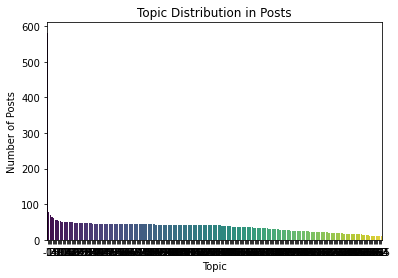

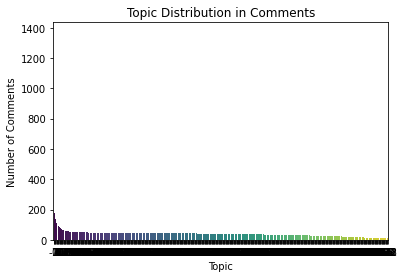

AttributeError: 'BERTopic' object has no attribute 'get_coherence'

In [ ]:
# Install BERTopic if not already installed


from bertopic import BERTopic
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Step 1: Prepare Data
# Ensure the text data is cleaned and formatted as a list of strings
post_texts = df_posts['Processed_Text'].dropna().tolist()
comment_texts = df_comments['Comment Body'].dropna().tolist()

# Step 2: Train BERTopic Model
# Posts Dataset
topic_model_posts = BERTopic()
topics_posts, probs_posts = topic_model_posts.fit_transform(post_texts)

# Comments Dataset
topic_model_comments = BERTopic()
topics_comments, probs_comments = topic_model_comments.fit_transform(comment_texts)

# Step 3: Visualize Topics
# Posts Topics
topic_model_posts.visualize_topics()

# Comments Topics
topic_model_comments.visualize_topics()

# # Visualize Hierarchical Structure
# topic_model_posts.visualize_hierarchy()
# topic_model_comments.visualize_hierarchy()

# Step 4: Analyze Topic Content
# Display top words in each topic for posts
print("Topics for Posts:")
for topic_id in range(len(topic_model_posts.get_topics())):
    print(f"Topic {topic_id}: {topic_model_posts.get_topic(topic_id)}")

# Display top words in each topic for comments
print("\nTopics for Comments:")
for topic_id in range(len(topic_model_comments.get_topics())):
    print(f"Topic {topic_id}: {topic_model_comments.get_topic(topic_id)}")

# Step 5: Save Model and Results
# Save BERTopic models
topic_model_posts.save("bertopic_posts_model")
topic_model_comments.save("bertopic_comments_model")

# Add topics to datasets
df_posts['BERTopic'] = topics_posts
df_comments['BERTopic'] = topics_comments

# Save datasets with topic assignments
df_posts.to_csv("posts_with_topics.csv", index=False)
df_comments.to_csv("comments_with_topics.csv", index=False)

# Step 6: Visualize Topic Distributions
# Posts topic distribution
sns.countplot(x=topics_posts, palette="viridis")
plt.title("Topic Distribution in Posts")
plt.xlabel("Topic")
plt.ylabel("Number of Posts")
plt.show()

# Comments topic distribution
sns.countplot(x=topics_comments, palette="viridis")
plt.title("Topic Distribution in Comments")
plt.xlabel("Topic")
plt.ylabel("Number of Comments")
plt.show()

# Step 7: Topic Coherence and Wordclouds
# Check Topic Coherence for posts
# coherence_posts = topic_model_posts.get_coherence()
# print(f"Coherence Score for Posts: {coherence_posts}")

# # Check Topic Coherence for comments
# coherence_comments = topic_model_comments.get_coherence()
# print(f"Coherence Score for Comments: {coherence_comments}")

# Visualize Wordclouds for Topics
# topic_model_posts.visualize_barchart(top_n_topics=10)
# topic_model_comments.visualize_barchart(top_n_topics=10)


In [29]:
# Visualize Wordclouds for Topics
topic_model_posts.visualize_barchart(top_n_topics=20)
#topic_model_comments.visualize_barchart(top_n_topics=10)

In [30]:
topic_model_comments.visualize_barchart(top_n_topics=20)

<h2>Classification Models </h2>

In [31]:
import xgboost as xgb
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Step 1: Ensure the target variable 'Risk_Level' does not contain NaN values
df_posts_clean = df_posts.dropna(subset=['Risk_Level'])

# Encode target variable as numerical labels (Low=0, Moderate=1, High=2)
df_posts_clean['Risk_Level'] = df_posts_clean['Risk_Level'].map({'Low': 0, 'Moderate': 1, 'High': 2})

# Step 2: Feature extraction
# Combine TF-IDF and Word2Vec matrices (assuming 'combined_features' is already created)
X = combined_features  # Features: concatenated TF-IDF + Word2Vec embeddings
y = df_posts_clean['Risk_Level']  # Target variable

# Step 3: Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

<h1>Other Models to be added</h1>

<h4>XGBoost Model</h4>

https://www.mdpi.com/1660-4601/19/19/12635

Accuracy: 0.943

Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.96      0.94       940
           1       0.99      0.84      0.91       231
           2       0.95      0.95      0.95       829

    accuracy                           0.94      2000
   macro avg       0.96      0.92      0.93      2000
weighted avg       0.94      0.94      0.94      2000



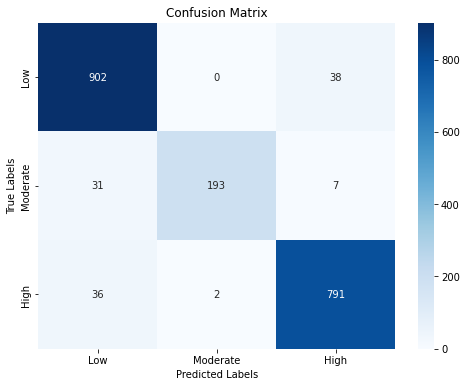

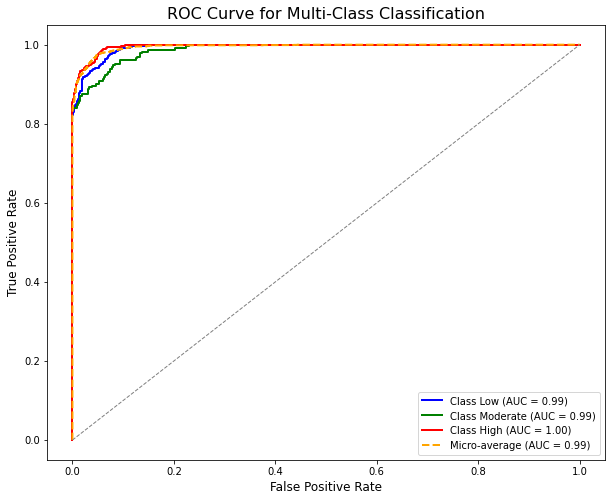

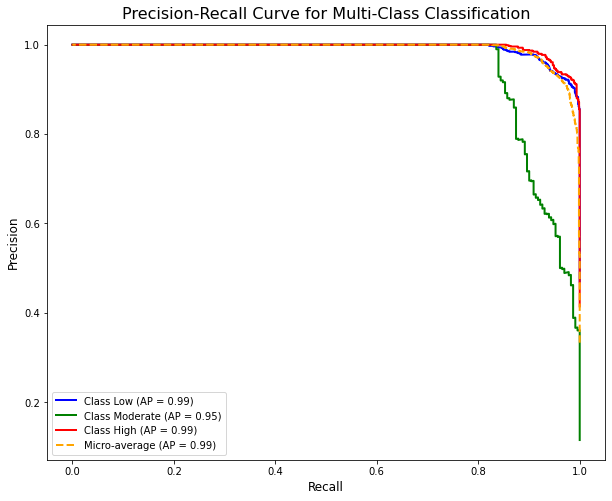

In [32]:

# Step 3: Train the XGBoost model
model = xgb.XGBClassifier(objective='multi:softmax', num_class=3, random_state=42)
model.fit(X_train, y_train)

# Step 4: Make predictions on the test set
y_pred = model.predict(X_test)

# Step 5: Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Step 7: Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Plotting the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=['Low', 'Moderate', 'High'], yticklabels=['Low', 'Moderate', 'High'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import numpy as np

# Step 4: Predict probabilities for the test set
y_pred_proba = model.predict_proba(X_test)

# Step 5: Binarize the true labels for multi-class AUC calculation
y_test_binarized = label_binarize(y_test, classes=[0, 1, 2])  # Assuming classes are 0, 1, 2

# Step 6: Compute ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
n_classes = y_test_binarized.shape[1]

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], y_pred_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_binarized.ravel(), y_pred_proba.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Step 7: Plot ROC curve for each class
plt.figure(figsize=(10, 8))
colors = ['blue', 'green', 'red']
class_names = ['Low', 'Moderate', 'High']

for i, color in enumerate(colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2, label=f'Class {class_names[i]} (AUC = {roc_auc[i]:.2f})')

# Plot micro-average ROC curve
plt.plot(fpr["micro"], tpr["micro"], color='orange', linestyle='--', lw=2, label=f'Micro-average (AUC = {roc_auc["micro"]:.2f})')

# Plot diagonal line (random guess)
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', lw=1)

# Add labels, legend, and title
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curve for Multi-Class Classification', fontsize=16)
plt.legend(loc='lower right', fontsize=10)
plt.show()

from sklearn.metrics import precision_recall_curve, average_precision_score

# Step 8: Compute Precision-Recall curve and Average Precision (AP) for each class
precision = dict()
recall = dict()
average_precision = dict()

for i in range(n_classes):
    precision[i], recall[i], _ = precision_recall_curve(y_test_binarized[:, i], y_pred_proba[:, i])
    average_precision[i] = average_precision_score(y_test_binarized[:, i], y_pred_proba[:, i])

# Compute micro-average Precision-Recall curve and Average Precision
precision["micro"], recall["micro"], _ = precision_recall_curve(y_test_binarized.ravel(), y_pred_proba.ravel())
average_precision["micro"] = average_precision_score(y_test_binarized, y_pred_proba, average="micro")

# Step 9: Plot Precision-Recall curve for each class
plt.figure(figsize=(10, 8))

for i, color in enumerate(colors):
    plt.plot(recall[i], precision[i], color=color, lw=2, label=f'Class {class_names[i]} (AP = {average_precision[i]:.2f})')

# Plot micro-average Precision-Recall curve
plt.plot(recall["micro"], precision["micro"], color='orange', linestyle='--', lw=2, label=f'Micro-average (AP = {average_precision["micro"]:.2f})')

# Add labels, legend, and title
plt.xlabel('Recall', fontsize=12)
plt.ylabel('Precision', fontsize=12)
plt.title('Precision-Recall Curve for Multi-Class Classification', fontsize=16)
plt.legend(loc='lower left', fontsize=10)
plt.show()



<h2>SHAP</h2>

<h3>Random Forest</h3>

https://www.mdpi.com/2076-3417/14/21/9911

Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.97      0.95       940
           1       1.00      0.84      0.91       231
           2       0.96      0.96      0.96       829

    accuracy                           0.95      2000
   macro avg       0.96      0.92      0.94      2000
weighted avg       0.95      0.95      0.95      2000

Accuracy: 0.95


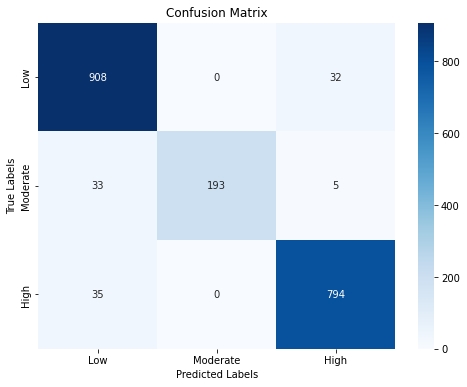

Macro-Average AUC: 0.99


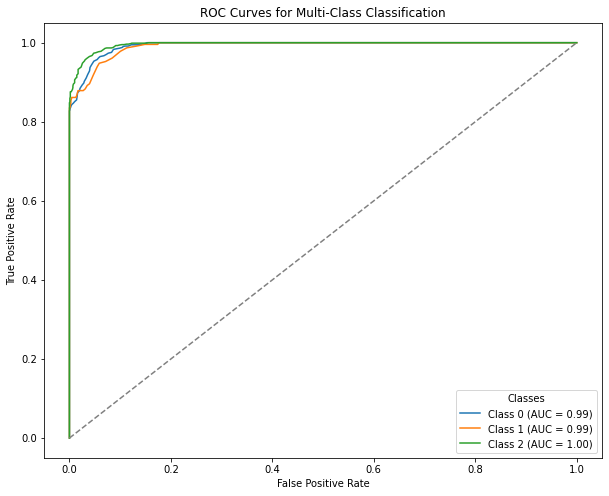

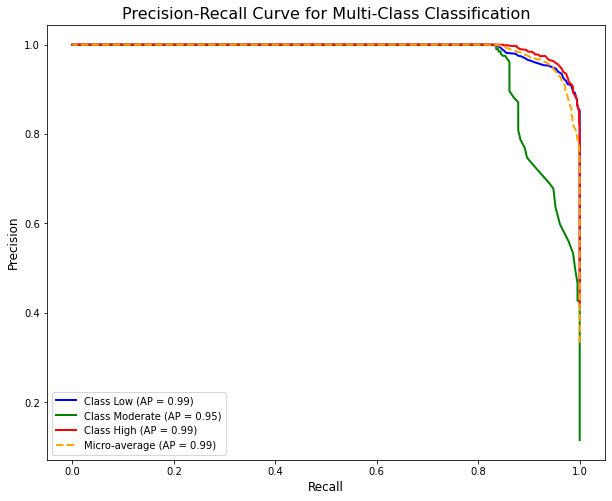

In [39]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, roc_curve, precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Step 4: Train the Random Forest model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)  # You can adjust n_estimators as needed
rf_model.fit(X_train, y_train)

# Step 5: Make predictions on the test set
y_pred = rf_model.predict(X_test)
y_pred_prob = rf_model.predict_proba(X_test)

# Step 6: Evaluate the model
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=['Low', 'Moderate', 'High'], yticklabels=['Low', 'Moderate', 'High'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

# Step 7: AUC-ROC Curve
if len(np.unique(y_test)) == 2:  # Binary classification
    auc = roc_auc_score(y_test, y_pred_prob[:, 1])
    fpr, tpr, _ = roc_curve(y_test, y_pred_prob[:, 1])
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label=f"AUC = {auc:.2f}", color='blue')
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
    plt.title('ROC Curve')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc='lower right')
    plt.show()
else:  # Multi-class classification
    from sklearn.preprocessing import label_binarize

    # Binarize the labels for multi-class AUC
    y_test_binarized = label_binarize(y_test, classes=[0, 1, 2])
    auc = roc_auc_score(y_test_binarized, y_pred_prob, average='macro', multi_class='ovr')

    print(f"Macro-Average AUC: {auc:.2f}")

    # Optional: Plot ROC curves for each class
    plt.figure(figsize=(10, 8))
    for i in range(y_test_binarized.shape[1]):
        fpr, tpr, _ = roc_curve(y_test_binarized[:, i], y_pred_prob[:, i])
        plt.plot(fpr, tpr, label=f'Class {i} (AUC = {roc_auc_score(y_test_binarized[:, i], y_pred_prob[:, i]):.2f})')

    plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
    plt.title('ROC Curves for Multi-Class Classification')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(title='Classes', loc='lower right')
    plt.show()

# Step 8: Precision-Recall Curve
precision = dict()
recall = dict()
average_precision = dict()

for i in range(y_test_binarized.shape[1]):
    precision[i], recall[i], _ = precision_recall_curve(y_test_binarized[:, i], y_pred_prob[:, i])
    average_precision[i] = average_precision_score(y_test_binarized[:, i], y_pred_prob[:, i])

# Compute micro-average Precision-Recall curve and Average Precision
precision["micro"], recall["micro"], _ = precision_recall_curve(y_test_binarized.ravel(), y_pred_prob.ravel())
average_precision["micro"] = average_precision_score(y_test_binarized, y_pred_prob, average="micro")

# Step 9: Plot Precision-Recall curve for each class
plt.figure(figsize=(10, 8))

colors = ['blue', 'green', 'red']  # Assign colors for each class
class_names = ['Low', 'Moderate', 'High']  # Update class names as needed

for i, color in enumerate(colors):
    plt.plot(recall[i], precision[i], color=color, lw=2, label=f'Class {class_names[i]} (AP = {average_precision[i]:.2f})')

# Plot micro-average Precision-Recall curve
plt.plot(recall["micro"], precision["micro"], color='orange', linestyle='--', lw=2, label=f'Micro-average (AP = {average_precision["micro"]:.2f})')

# Add labels, legend, and title
plt.xlabel('Recall', fontsize=12)
plt.ylabel('Precision', fontsize=12)
plt.title('Precision-Recall Curve for Multi-Class Classification', fontsize=16)
plt.legend(loc='lower left', fontsize=10)
plt.show()


<h2>BERT model</h2>

In [ ]:
# from transformers import BertTokenizer, BertModel

# # Step 1: Load pre-trained BERT tokenizer
# try:
#     tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
#     print("BERT Tokenizer loaded successfully.")
# except Exception as e:
#     print(f"Error loading BERT Tokenizer: {e}")

# # Step 2: Load pre-trained BERT model
# try:
#     model = BertModel.from_pretrained('bert-base-uncased')
#     print("BERT Model loaded successfully.")
# except Exception as e:
#     print(f"Error loading BERT Model: {e}")

# # Step 3: Test tokenization and model output
# try:
#     # Example text
#     text = "This is a test to see if BERT works correctly."

#     # Tokenize the text
#     inputs = tokenizer(text, return_tensors="pt")
#     print(f"Tokenized input: {inputs}")

#     # Pass tokenized input through the BERT model
#     outputs = model(**inputs)
#     print("Model output keys:", outputs.keys())  # Should display 'last_hidden_state' and 'pooler_output'
#     print("BERT Model test successful.")
# except Exception as e:
#     print(f"Error using BERT Model: {e}")

In [ ]:
# import pandas as pd
# import torch
# from torch.utils.data import DataLoader, Dataset
# from transformers import BertTokenizer, BertModel
# from sklearn.model_selection import train_test_split
# from sklearn.linear_model import LogisticRegression
# from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
# import seaborn as sns
# import matplotlib.pyplot as plt

# # Ensure the required columns exist
# print("Columns in the DataFrame:", df_posts.columns)

# # Check for missing columns
# required_columns = ['Processed_Text', 'Risk_Level']
# for col in required_columns:
#     if col not in df_posts.columns:
#         raise KeyError(f"Column '{col}' is missing in the DataFrame. Please verify the preprocessing steps.")

# # Map risk levels to numerical labels if not already mapped
# if df_posts['Risk_Level'].dtype == 'object':
#     df_posts['Risk_Level'] = df_posts['Risk_Level'].map({'Low': 0, 'Moderate': 1, 'High': 2})

# # Drop rows with missing values in required columns
# df_posts = df_posts.dropna(subset=['Processed_Text', 'Risk_Level'])

# # Step 1: Load the pre-trained BERT model and tokenizer
# tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
# bert_model = BertModel.from_pretrained('bert-base-uncased')
# bert_model.eval()  # Set model to evaluation mode

# # Step 2: Define a Dataset class for BERT embeddings
# class BERTDataset(Dataset):
#     def __init__(self, texts, tokenizer, max_length=512):
#         self.texts = texts
#         self.tokenizer = tokenizer
#         self.max_length = max_length

#     def __len__(self):
#         return len(self.texts)

#     def __getitem__(self, idx):
#         text = self.texts[idx]
#         return self.tokenizer(
#             text,
#             return_tensors="pt",
#             truncation=True,
#             padding="max_length",
#             max_length=self.max_length
#         )

# # Step 3: Extract BERT embeddings in batches

# def extract_bert_embeddings(dataloader, model):
#     embeddings = []
#     with torch.no_grad():
#         for batch in dataloader:
#             input_ids = batch['input_ids'].squeeze(1).to(model.device)  # Adjust for batch shape
#             attention_mask = batch['attention_mask'].squeeze(1).to(model.device)
#             outputs = model(input_ids=input_ids, attention_mask=attention_mask)
#             hidden_states = outputs.last_hidden_state
#             pooled_embeddings = torch.mean(hidden_states, dim=1)  # Mean pooling
#             embeddings.extend(pooled_embeddings.cpu().numpy())
#     return embeddings

# # Prepare the dataset and dataloader
# texts = df_posts['Processed_Text'].tolist()
# dataset = BERTDataset(texts, tokenizer)
# dataloader = DataLoader(dataset, batch_size=16, shuffle=False)

# print("Extracting BERT embeddings in batches...")
# bert_model.to(torch.device("cuda" if torch.cuda.is_available() else "cpu"))  # Move model to GPU if available
# bert_embeddings = extract_bert_embeddings(dataloader, bert_model)
# print("BERT embeddings extraction complete.")

# # Add embeddings back to the DataFrame
# df_posts['BERT_Embeddings'] = bert_embeddings

# # Convert embeddings to a matrix
# X = torch.stack([torch.tensor(embedding) for embedding in bert_embeddings]).numpy()
# y = df_posts['Risk_Level'].values

# # Step 4: Split the data into train and test sets
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# # Step 5: Train a classifier on BERT embeddings
# clf = LogisticRegression(max_iter=1000, random_state=42)
# clf.fit(X_train, y_train)

# # Step 6: Make predictions and evaluate
# y_pred = clf.predict(X_test)
# print("Classification Report:")
# print(classification_report(y_test, y_pred))
# print("Accuracy:", accuracy_score(y_test, y_pred))

# # Step 7: Visualize the confusion matrix
# conf_matrix = confusion_matrix(y_test, y_pred)
# plt.figure(figsize=(8, 6))
# sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=['Low', 'Moderate', 'High'], yticklabels=['Low', 'Moderate', 'High'])
# plt.title('Confusion Matrix')
# plt.xlabel('Predicted Labels')
# plt.ylabel('True Labels')
# plt.show()


Save the Model

In [ ]:
# import joblib

# # Save the trained model to a file
# joblib.dump(clf, 'bert_logistic_model.pkl')
# print("Model saved successfully.")

Load the Model

In [ ]:
# # Load the model from the file
# loaded_model = joblib.load('bert_logistic_model.pkl')
# print("Model loaded successfully.")

# # Use the loaded model to make predictions
# y_pred_loaded = loaded_model.predict(X_test)
# print("Accuracy of loaded model:", accuracy_score(y_test, y_pred_loaded))

Save and Load BERT Embeddings

In [ ]:
# # Save BERT embeddings
# import numpy as np
# np.save('bert_embeddings.npy', X)

# # Save labels
# np.save('labels.npy', y)

# # Load BERT embeddings and labels
# X_loaded = np.load('bert_embeddings.npy')
# y_loaded = np.load('labels.npy')

Model loaded successfully.
Embeddings and labels loaded successfully.
Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.94      0.94       940
           1       0.91      0.86      0.88       231
           2       0.94      0.96      0.95       829

    accuracy                           0.94      2000
   macro avg       0.93      0.92      0.93      2000
weighted avg       0.94      0.94      0.94      2000



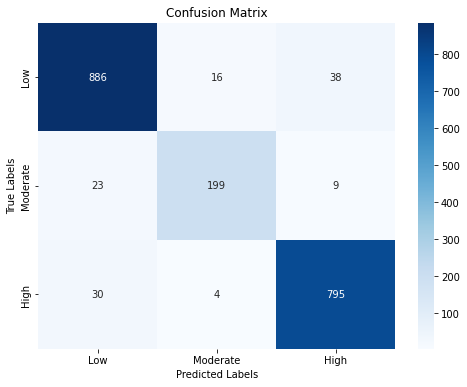

Macro-Average AUC: 0.97


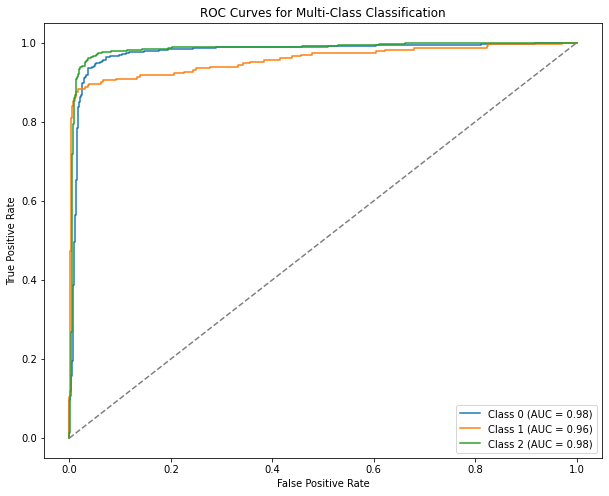

In [41]:
import numpy as np
import joblib
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
import seaborn as sns
import matplotlib.pyplot as plt

# Step 1: Load saved model, embeddings, and labels
loaded_model = joblib.load('bert_logistic_model.pkl')
print("Model loaded successfully.")

X_loaded = np.load('bert_embeddings.npy')  # BERT embeddings
y_loaded = np.load('labels.npy')  # Corresponding labels
print("Embeddings and labels loaded successfully.")

# Step 2: Split the data into train and test sets (same random state as before)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_loaded, y_loaded, test_size=0.2, random_state=42)

# Step 3: Use the loaded model to make predictions
y_pred_loaded = loaded_model.predict(X_test)
y_pred_prob = loaded_model.predict_proba(X_test)

# Step 4: Generate and display classification report
print("Classification Report:")
print(classification_report(y_test, y_pred_loaded))

# Step 5: Generate and display confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_loaded)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=['Low', 'Moderate', 'High'], yticklabels=['Low', 'Moderate', 'High'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

# Step 6: Calculate and plot AUC-ROC curve
if len(np.unique(y_test)) == 2:  # Binary classification
    auc = roc_auc_score(y_test, y_pred_prob[:, 1])
    fpr, tpr, _ = roc_curve(y_test, y_pred_prob[:, 1])
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='blue', label=f'AUC = {auc:.2f}')
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
    plt.title('ROC Curve')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc='lower right')
    plt.show()
else:  # Multi-class classification
    from sklearn.preprocessing import label_binarize
    from sklearn.metrics import roc_auc_score

    # Binarize the labels for multi-class AUC
    y_test_binarized = label_binarize(y_test, classes=[0, 1, 2])
    auc = roc_auc_score(y_test_binarized, y_pred_prob, average='macro', multi_class='ovr')

    print(f"Macro-Average AUC: {auc:.2f}")
    # Optional: Plot ROC curves for each class
    plt.figure(figsize=(10, 8))
    for i in range(y_test_binarized.shape[1]):
        fpr, tpr, _ = roc_curve(y_test_binarized[:, i], y_pred_prob[:, i])
        plt.plot(fpr, tpr, label=f'Class {i} (AUC = {roc_auc_score(y_test_binarized[:, i], y_pred_prob[:, i]):.2f})')

    plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
    plt.title('ROC Curves for Multi-Class Classification')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc='lower right')
    plt.show()

<h3>CNN</h3>

https://www.mdpi.com/1660-4601/19/16/10347

2025-01-03 05:37:17.177316: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1
2025-01-03 05:37:17.180684: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 8.00 GB
2025-01-03 05:37:17.180692: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 2.67 GB
2025-01-03 05:37:17.180937: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-01-03 05:37:17.181346: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Epoch 1/50


2025-01-03 05:37:20.704652: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


250/250 ━━━━━━━━━━━━━━━━━━━━ 7s 22ms/step - accuracy: 0.4567 - loss: 1.0144 - val_accuracy: 0.4700 - val_loss: 0.9677
Epoch 2/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 7s 27ms/step - accuracy: 0.4755 - loss: 0.9729 - val_accuracy: 0.4760 - val_loss: 0.9599
Epoch 3/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 6s 24ms/step - accuracy: 0.4858 - loss: 0.9641 - val_accuracy: 0.4700 - val_loss: 0.9660
Epoch 4/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 6s 23ms/step - accuracy: 0.4817 - loss: 0.9590 - val_accuracy: 0.5090 - val_loss: 0.9542
Epoch 5/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 6s 22ms/step - accuracy: 0.4993 - loss: 0.9559 - val_accuracy: 0.4945 - val_loss: 0.9497
Epoch 6/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 5s 22ms/step - accuracy: 0.5106 - loss: 0.9462 - val_accuracy: 0.4960 - val_loss: 0.9483
Epoch 7/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 5s 22ms/step - accuracy: 0.5140 - loss: 0.9460 - val_accuracy: 0.4845 - val_loss: 0.9470
Epoch 8/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 6s 23ms/step - accuracy: 0.4927 - loss: 0.9518 - val_accuracy: 0.500

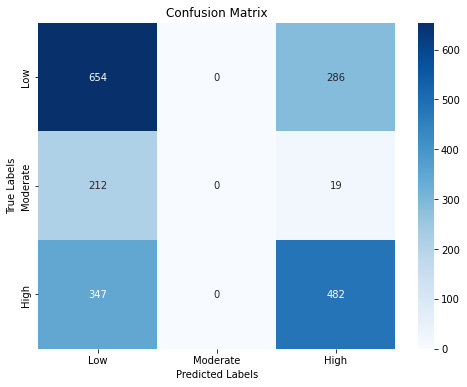

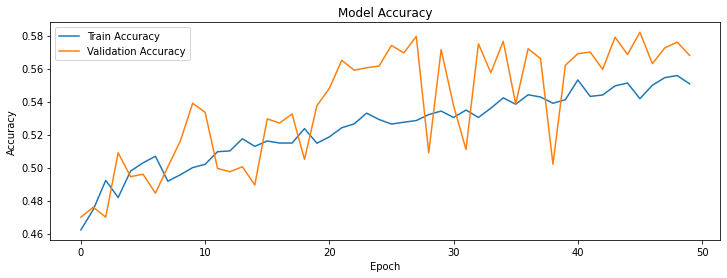

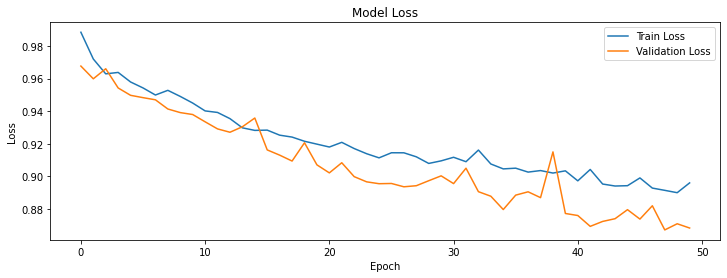

In [42]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense, Dropout, Flatten
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Step 1: Prepare data (use pre-computed embeddings like Word2Vec/BERT)
X = np.load('bert_embeddings.npy')  # Use your precomputed embeddings
y = np.load('labels.npy')  # Corresponding labels

# One-hot encode labels for multi-class classification
y = to_categorical(y, num_classes=3)  # Assuming 3 classes: Low, Moderate, High

# Step 2: Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 3: Build CNN model
model = Sequential()

# Add convolutional layers
model.add(Conv1D(filters=128, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], 1)))
model.add(GlobalMaxPooling1D())

# Add dense layers for classification
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(3, activation='softmax'))  # 3 classes for multi-class classification

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Step 4: Train the CNN
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=50,
    batch_size=32,
    verbose=1
)

# Step 5: Evaluate the model
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=1)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

# Step 6: Generate predictions and classification report
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_test_classes = np.argmax(y_test, axis=1)

print("Classification Report:")
print(classification_report(y_test_classes, y_pred_classes, target_names=['Low', 'Moderate', 'High']))

# Step 7: Plot confusion matrix
conf_matrix = confusion_matrix(y_test_classes, y_pred_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Low', 'Moderate', 'High'], yticklabels=['Low', 'Moderate', 'High'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

# Optional: Plot training history
plt.figure(figsize=(12, 4))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.figure(figsize=(12, 4))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

<h3>Permormance Statistics Across Models</h3>

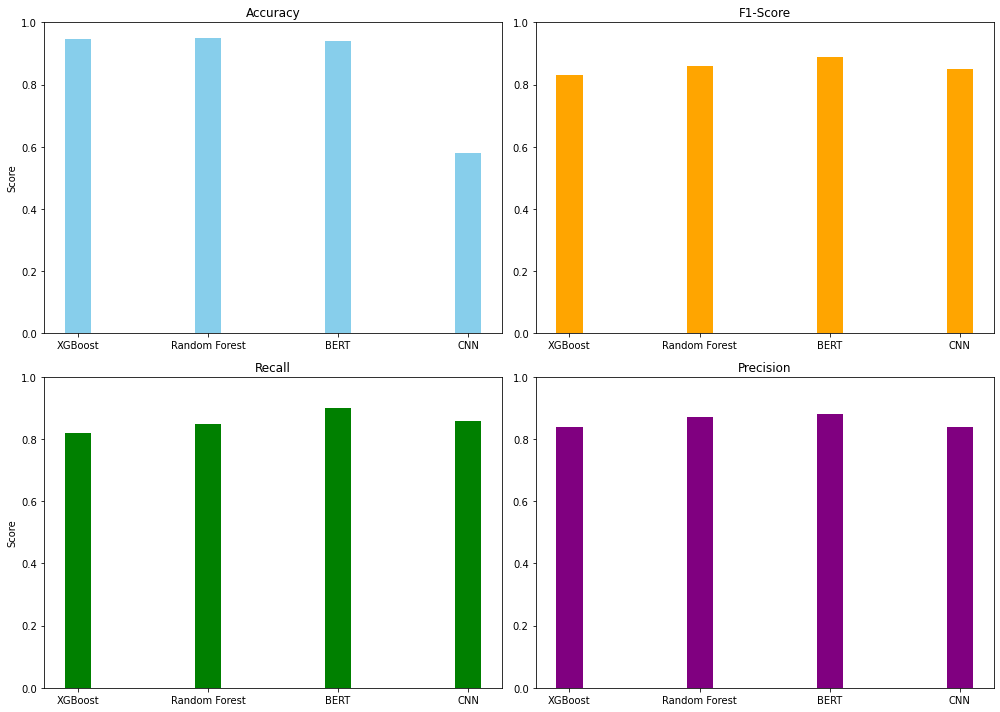

In [43]:
import matplotlib.pyplot as plt
import numpy as np

# Sample metrics for each model (replace these values with actual results from your models)
metrics = {
    "XGBoost": {"Accuracy": 0.945, "F1-Score": 0.83, "Recall": 0.82, "Precision": 0.84},
    "Random Forest": {"Accuracy": 0.95, "F1-Score": 0.86, "Recall": 0.85, "Precision": 0.87},
    "BERT": {"Accuracy": 0.94, "F1-Score": 0.89, "Recall": 0.90, "Precision": 0.88},
    "CNN": {"Accuracy": 0.58, "F1-Score": 0.85, "Recall": 0.86, "Precision": 0.84},
}

# Extract metrics for plotting
models = list(metrics.keys())
accuracy = [metrics[model]["Accuracy"] for model in models]
f1_score = [metrics[model]["F1-Score"] for model in models]
recall = [metrics[model]["Recall"] for model in models]
precision = [metrics[model]["Precision"] for model in models]

# Plot settings
x = np.arange(len(models))  # label locations
width = 0.2  # bar width

# Create subplots for each metric
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Accuracy
axes[0, 0].bar(x, accuracy, width, label='Accuracy', color='skyblue')
axes[0, 0].set_title('Accuracy')
axes[0, 0].set_xticks(x)
axes[0, 0].set_xticklabels(models)
axes[0, 0].set_ylim(0, 1)
axes[0, 0].set_ylabel('Score')

# F1-Score
axes[0, 1].bar(x, f1_score, width, label='F1-Score', color='orange')
axes[0, 1].set_title('F1-Score')
axes[0, 1].set_xticks(x)
axes[0, 1].set_xticklabels(models)
axes[0, 1].set_ylim(0, 1)

# Recall
axes[1, 0].bar(x, recall, width, label='Recall', color='green')
axes[1, 0].set_title('Recall')
axes[1, 0].set_xticks(x)
axes[1, 0].set_xticklabels(models)
axes[1, 0].set_ylim(0, 1)
axes[1, 0].set_ylabel('Score')

# Precision
axes[1, 1].bar(x, precision, width, label='Precision', color='purple')
axes[1, 1].set_title('Precision')
axes[1, 1].set_xticks(x)
axes[1, 1].set_xticklabels(models)
axes[1, 1].set_ylim(0, 1)

# Adjust layout
fig.tight_layout()
plt.show()

<h1>Community Support Analysis</h1>

<h4>Comments empathy label</h4> 

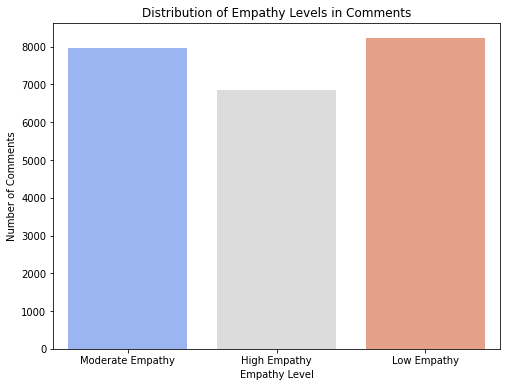

In [44]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
analyzer = SentimentIntensityAnalyzer()

# Define a function to classify Empathy_Level
def classify_empathy_level(text):
    sentiment_score = analyzer.polarity_scores(text)['compound']
    if sentiment_score > 0.5:  # Strongly positive
        return 'High Empathy'
    elif 0 <= sentiment_score <= 0.5:  # Neutral to slightly positive
        return 'Moderate Empathy'
    else:  # Negative sentiment
        return 'Low Empathy'

# Apply to the comments dataset
df_comments['Empathy_Level'] = df_comments['Comment Body'].apply(classify_empathy_level)

import seaborn as sns
import matplotlib.pyplot as plt

# Plotting the distribution of the Empathy_Level column
plt.figure(figsize=(8, 6))
sns.countplot(data=df_comments, x='Empathy_Level', palette='coolwarm')
plt.title('Distribution of Empathy Levels in Comments')
plt.xlabel('Empathy Level')
plt.ylabel('Number of Comments')
plt.show()



<h3>Data Exploration</h3>

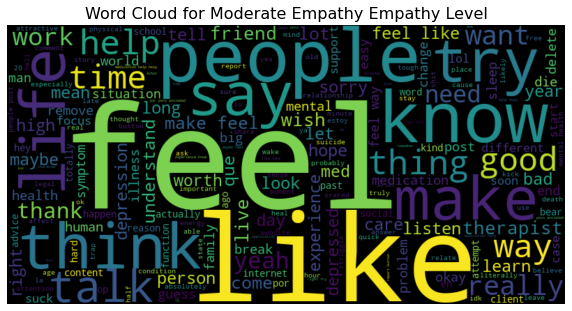

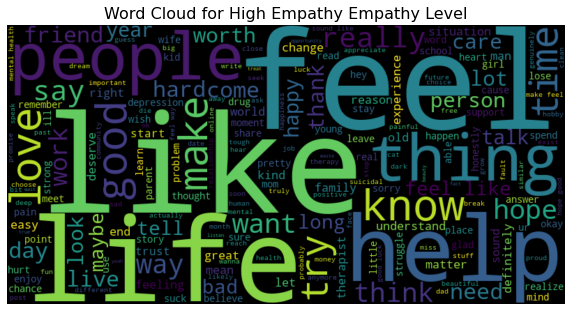

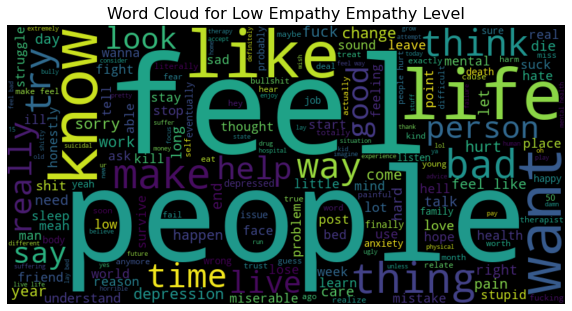

In [45]:
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer
from nltk.util import ngrams
from collections import Counter

# Ensure 'Empathy_Level' column is filled appropriately
df_comments['Empathy_Level'] = df_comments['Empathy_Level'].fillna('No Empathy')  # Handle missing labels

# Define a function to extract n-grams
def extract_ngrams(texts, n=1):
    vectorizer = CountVectorizer(ngram_range=(n, n), stop_words='english')
    ngram_counts = vectorizer.fit_transform(texts)
    ngram_features = vectorizer.get_feature_names_out()
    ngram_frequencies = ngram_counts.toarray().sum(axis=0)
    return dict(zip(ngram_features, ngram_frequencies))

# Generate word clouds for each empathy level
empathy_levels = df_comments['Empathy_Level'].unique()

for empathy_level in empathy_levels:
    # Filter the comments for the specific empathy level
    texts = df_comments[df_comments['Empathy_Level'] == empathy_level]['Comment Body'].dropna()
    
    # Extract n-grams
    unigram_counts = extract_ngrams(texts, n=1)
    bigram_counts = extract_ngrams(texts, n=2)
    trigram_counts = extract_ngrams(texts, n=3)
    
    # Combine all n-grams into a single dictionary
    combined_counts = Counter(unigram_counts) + Counter(bigram_counts) + Counter(trigram_counts)
    
    # Get the top 300 n-grams
    top_ngrams = dict(combined_counts.most_common(300))
    
    # Generate word cloud
    wordcloud = WordCloud(width=800, height=400, background_color='black').generate_from_frequencies(top_ngrams)
    
    # Plot the word cloud
    plt.figure(figsize=(10, 6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(f'Word Cloud for {empathy_level} Empathy Level', fontsize=16)
    plt.axis('off')
    plt.show()

<h3>Identifying Patterns in Actionable Support and Their Impact</h3>

In [46]:
import pandas as pd

# Load the posts datasets
depression_posts = pd.read_csv('depression_posts.csv')
suicidewatch_posts = pd.read_csv('SuicideWatch_posts.csv')

# Combine all posts into a single DataFrame
df_posts = pd.concat([depression_posts, suicidewatch_posts], ignore_index=True)

# Load the comments datasets
depression_comments = pd.read_csv('depression_comments.csv')
suicidewatch_comments = pd.read_csv('SuicideWatch_comments.csv')

# Combine all comments into a single DataFrame
df_comments = pd.concat([depression_comments, suicidewatch_comments], ignore_index=True)

# Check the structure of the combined datasets
print("Posts Dataset Shape:", df_posts.shape)
print("Comments Dataset Shape:", df_comments.shape)

Posts Dataset Shape: (10000, 9)
Comments Dataset Shape: (23042, 7)


In [47]:
# Check for missing values and fill/drop them as needed
df_posts = df_posts.dropna(subset=['Content', 'Post ID'])  # Ensure no missing content or Post IDs
df_comments = df_comments.dropna(subset=['Comment Body', 'Post ID'])  # Ensure no missing comments or Post IDs

# Ensure Post ID matches between posts and comments
post_ids_posts = set(df_posts['Post ID'])
post_ids_comments = set(df_comments['Post ID'])
shared_post_ids = post_ids_posts.intersection(post_ids_comments)

# Filter posts and comments based on shared Post IDs
df_posts = df_posts[df_posts['Post ID'].isin(shared_post_ids)]
df_comments = df_comments[df_comments['Post ID'].isin(shared_post_ids)]

print(f"Number of Shared Posts Between Datasets: {len(shared_post_ids)}")

Number of Shared Posts Between Datasets: 1116


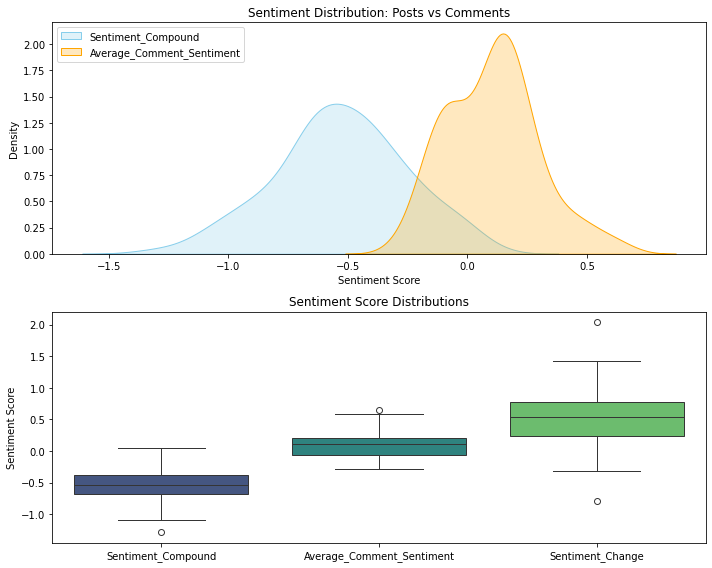

In [48]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

# Generate example data
np.random.seed(42)

# Simulated sentiment data for posts and comments
data = {
    "Sentiment_Compound": np.random.normal(loc=-0.5, scale=0.3, size=100),
    "Average_Comment_Sentiment": np.random.normal(loc=0.1, scale=0.2, size=100),
    "Sentiment_Change": np.random.normal(loc=0.5, scale=0.4, size=100)
}

df = pd.DataFrame(data)

# Create the first plot: Density Plot
plt.figure(figsize=(10, 8))
plt.subplot(2, 1, 1)
sns.kdeplot(df['Sentiment_Compound'], shade=True, label='Sentiment_Compound', color='skyblue')
sns.kdeplot(df['Average_Comment_Sentiment'], shade=True, label='Average_Comment_Sentiment', color='orange')
plt.title('Sentiment Distribution: Posts vs Comments')
plt.xlabel('Sentiment Score')
plt.ylabel('Density')
plt.legend()

# Create the second plot: Boxplot
plt.subplot(2, 1, 2)
sns.boxplot(data=df, palette="viridis")
plt.title('Sentiment Score Distributions')
plt.ylabel('Sentiment Score')
plt.xticks(ticks=[0, 1, 2], labels=['Sentiment_Compound', 'Average_Comment_Sentiment', 'Sentiment_Change'])

# Adjust layout and display
plt.tight_layout()
plt.show()

<h3>twitter-roberta-base-sentiment(general-purpose sentiment model)</h3>

In [49]:
from transformers import pipeline

# Step 1: Load the sentiment-analysis pipeline
try:
    # Using a pre-trained model like cardiffnlp/twitter-roberta-base-sentiment
    sentiment_analyzer = pipeline("sentiment-analysis", model="cardiffnlp/twitter-roberta-base-sentiment")
    print("Transformer-based model loaded successfully!")
except Exception as e:
    print(f"Error loading transformer-based model: {e}")

# Step 2: Test the model with a sample comment
try:
    sample_comment = "I understand how you feel, and I am here to help you through this."
    result = sentiment_analyzer(sample_comment)
    print(f"Sample comment analysis result: {result}")
except Exception as e:
    print(f"Error during comment analysis: {e}")

Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.


Transformer-based model loaded successfully!
Sample comment analysis result: [{'label': 'LABEL_2', 'score': 0.5669693350791931}]


In [50]:
import pandas as pd
from transformers import pipeline

# Step 1: Load the transformer-based sentiment-analysis pipeline
try:
    sentiment_analyzer = pipeline("sentiment-analysis", model="cardiffnlp/twitter-roberta-base-sentiment")
    print("Transformer-based model loaded successfully!")
except Exception as e:
    print(f"Error loading transformer-based model: {e}")

# Ensure Post ID is consistent across datasets
df_comments['Post ID'] = df_comments['Post ID'].astype(str)
df_posts['Post ID'] = df_posts['Post ID'].astype(str)

# Filter posts with no associated comments
filtered_posts_ids = df_comments['Post ID'].unique()  # Get unique Post IDs from comments
df_posts = df_posts[df_posts['Post ID'].isin(filtered_posts_ids)]  # Keep only posts with comments

print(f"Filtered posts count: {df_posts.shape[0]}")

# Function to analyze sentiment of comments using transformer-based model
def analyze_comment_sentiment(comment):
    try:
        result = sentiment_analyzer(comment)[0]
        # Use the label and score from the transformer model
        return result['label'], result['score']  # e.g., 'LABEL_0', 0.85
    except Exception as e:
        return "Neutral", 0.0  # Default label and score if analysis fails

# Apply sentiment analysis to all comments
df_comments[['Sentiment_Label', 'Sentiment_Score']] = df_comments['Comment Body'].apply(
    lambda comment: pd.Series(analyze_comment_sentiment(comment))
)

# Aggregate sentiment by post
aggregated_metrics = df_comments.groupby('Post ID').agg({
    'Sentiment_Score': ['mean', 'std'],  # Average sentiment and variation
}).reset_index()
aggregated_metrics.columns = ['Post ID', 'Avg_Sentiment', 'Sentiment_StdDev']

# Check aggregated metrics
print(aggregated_metrics.head())

# Drop conflicting columns if they exist in df_posts
columns_to_drop = ['Avg_Sentiment', 'Sentiment_StdDev']
df_posts = df_posts.drop(columns=[col for col in columns_to_drop if col in df_posts.columns], errors='ignore')

# Merge sentiment metrics with posts dataset
df_posts = df_posts.merge(aggregated_metrics, on='Post ID', how='left')

# Fill missing values after merge
df_posts['Avg_Sentiment'] = df_posts['Avg_Sentiment'].fillna(0)
df_posts['Sentiment_StdDev'] = df_posts['Sentiment_StdDev'].fillna(0)

# Function to classify de-escalation
def classify_risk_change(avg_sentiment):
    if avg_sentiment > 0.8:  # Relaxed threshold for supportive comments
        return "Supportive Impact"
    return "Neutral Impact"

# Apply risk change classification
df_posts['Risk_Change'] = df_posts['Avg_Sentiment'].apply(classify_risk_change)

# Save results
df_posts.to_csv('posts_with_risk_change_transformer.csv', index=False)

# Display results
print(df_posts[['Post Title', 'Risk_Change', 'Avg_Sentiment']].head())

Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.


Transformer-based model loaded successfully!
Filtered posts count: 5576
   Post ID  Avg_Sentiment  Sentiment_StdDev
0  1g8apv0       0.654565               NaN
1  1g8ar1i       0.800216          0.000000
2  1g8avcc       0.978898          0.000000
3  1g8avnz       0.666850          0.206545
4  1g8b83i       0.716918          0.000000
                                          Post Title        Risk_Change  \
0                                       Agomelatine   Supportive Impact   
1  The only reason I’m still here is because I’m ...     Neutral Impact   
2                     Sucks being poor and depressed  Supportive Impact   
3  How do I get over feeling depressed over a guy...     Neutral Impact   
4         Everything is against me and I’m losing it     Neutral Impact   

   Avg_Sentiment  
0       0.826882  
1       0.480147  
2       0.969268  
3       0.722152  
4       0.736247  


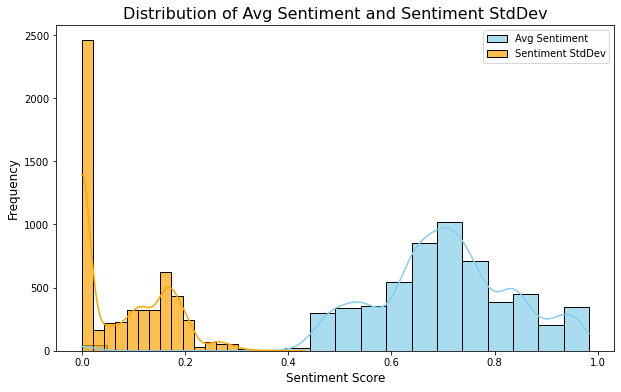

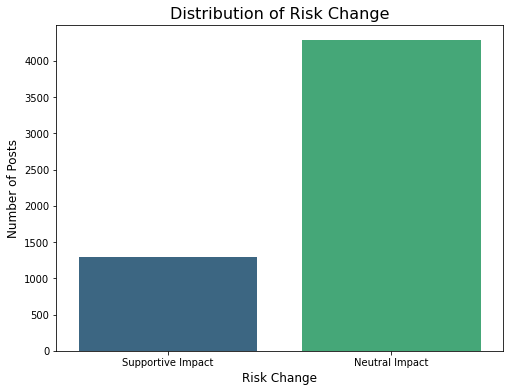

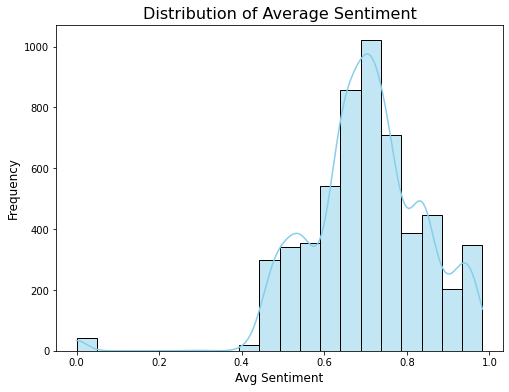

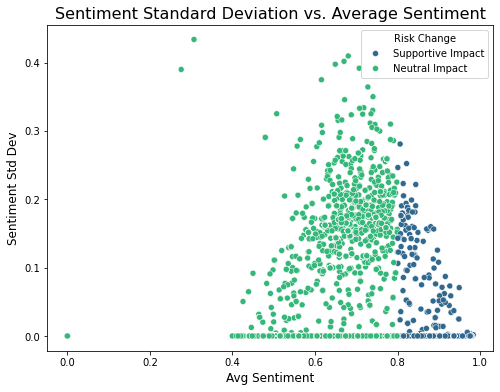

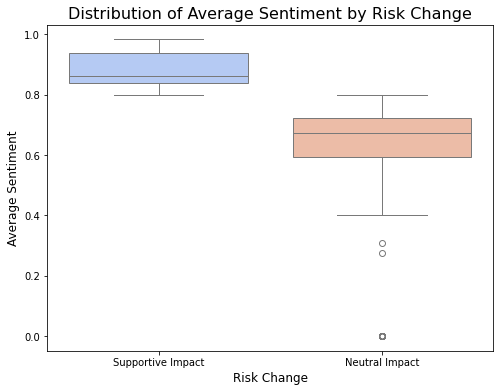

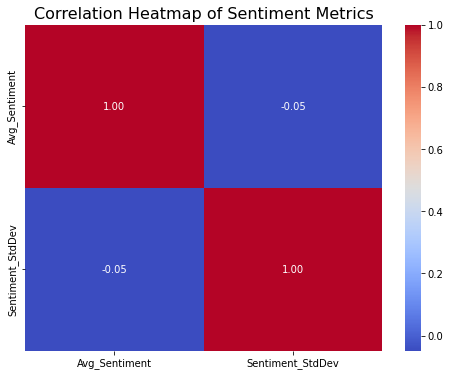

In [51]:
import matplotlib.pyplot as plt
import seaborn as sns

import matplotlib.pyplot as plt
import seaborn as sns

# Plot the distributions of Avg_Sentiment and Sentiment_StdDev
plt.figure(figsize=(10, 6))
sns.histplot(df_posts['Avg_Sentiment'], bins=20, kde=True, color='skyblue', label='Avg Sentiment', alpha=0.7)
sns.histplot(df_posts['Sentiment_StdDev'], bins=20, kde=True, color='orange', label='Sentiment StdDev', alpha=0.7)
plt.title('Distribution of Avg Sentiment and Sentiment StdDev', fontsize=16)
plt.xlabel('Sentiment Score', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.legend()
plt.show()

# Plot the distribution of Risk_Change
plt.figure(figsize=(8, 6))
sns.countplot(data=df_posts, x='Risk_Change', palette='viridis')
plt.title('Distribution of Risk Change', fontsize=16)
plt.xlabel('Risk Change', fontsize=12)
plt.ylabel('Number of Posts', fontsize=12)
plt.show()

# Plot the distribution of Avg_Sentiment
plt.figure(figsize=(8, 6))
sns.histplot(df_posts['Avg_Sentiment'], bins=20, kde=True, color='skyblue')
plt.title('Distribution of Average Sentiment', fontsize=16)
plt.xlabel('Avg Sentiment', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.show()

# Scatter plot of Avg_Sentiment vs. Sentiment_StdDev
plt.figure(figsize=(8, 6))
sns.scatterplot(data=df_posts, x='Avg_Sentiment', y='Sentiment_StdDev', hue='Risk_Change', palette='viridis')
plt.title('Sentiment Standard Deviation vs. Average Sentiment', fontsize=16)
plt.xlabel('Avg Sentiment', fontsize=12)
plt.ylabel('Sentiment Std Dev', fontsize=12)
plt.legend(title='Risk Change')
plt.show()

# Box Plot for Avg_Sentiment by Risk_Change
plt.figure(figsize=(8, 6))
sns.boxplot(data=df_posts, x='Risk_Change', y='Avg_Sentiment', palette='coolwarm')
plt.title('Distribution of Average Sentiment by Risk Change', fontsize=16)
plt.xlabel('Risk Change', fontsize=12)
plt.ylabel('Average Sentiment', fontsize=12)
plt.show()

# Correlation Heatmap
plt.figure(figsize=(8, 6))
correlation_matrix = df_posts[['Avg_Sentiment', 'Sentiment_StdDev']].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap of Sentiment Metrics', fontsize=16)
plt.show()

<h3>bert-base-uncased-emotion</h3>

https://huggingface.co/bhadresh-savani/bert-base-uncased-emotion

In [52]:
from transformers import pipeline

classifier = pipeline("text-classification", model="bhadresh-savani/bert-base-uncased-emotion",truncation=True)
print("Model loaded successfully!")

test_text = "I feel really sad today."
result = classifier(test_text)
print(result)  # It should return the emotion label with probabilities


Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.


Model loaded successfully!
[{'label': 'sadness', 'score': 0.998710036277771}]


In [53]:
test_text = "I love my life"
result = classifier(test_text)
print(result)  #

[{'label': 'joy', 'score': 0.8417611122131348}]


In [54]:
# Ensure Post ID is consistent across datasets
df_comments['Post ID'] = df_comments['Post ID'].astype(str)
df_posts['Post ID'] = df_posts['Post ID'].astype(str)

# Filter posts with no associated comments
filtered_posts_ids = df_comments['Post ID'].unique()  # Get unique Post IDs from comments
df_posts = df_posts[df_posts['Post ID'].isin(filtered_posts_ids)]  # Keep only posts with comments

print(f"Filtered posts count: {df_posts.shape[0]}")

# Function to split long comments into chunks (max 512 tokens per chunk)
def split_text_into_chunks(text, max_length=512):
    words = text.split()  # Split text into words
    chunks = []
    chunk = []
    length = 0

    for word in words:
        length += len(word) + 1  # Including space after word
        if length > max_length:
            chunks.append(" ".join(chunk))
            chunk = [word]
            length = len(word)
        else:
            chunk.append(word)
    
    if chunk:
        chunks.append(" ".join(chunk))  # Add remaining words as a chunk
    
    return chunks

# Function to analyze sentiment of comments and aggregate the results for long comments
def analyze_comment_sentiment(comment):
    try:
        chunks = split_text_into_chunks(comment)
        sentiments = []

        for chunk in chunks:
            result = classifier(chunk)[0]  # Analyze sentiment for each chunk
            sentiments.append(result['score'])  # You can also collect the labels if necessary
        
        # Return the average sentiment score for the entire comment
        avg_sentiment = sum(sentiments) / len(sentiments) if sentiments else 0.0
        return "Positive" if avg_sentiment > 0.8 else "Negative", avg_sentiment  # Return sentiment label and score

    except Exception as e:
        return "Neutral", 0.0  # Default label and score if analysis fails

# Apply sentiment analysis to all comments
df_comments[['Sentiment_Label', 'Sentiment_Score']] = df_comments['Comment Body'].apply(
    lambda comment: pd.Series(analyze_comment_sentiment(comment))
)

# Aggregate sentiment by post
aggregated_metrics = df_comments.groupby('Post ID').agg({
    'Sentiment_Score': ['mean', 'std'],  # Average sentiment and variation
}).reset_index()
aggregated_metrics.columns = ['Post ID', 'Avg_Sentiment', 'Sentiment_StdDev']

# Check aggregated metrics
print(aggregated_metrics.head())

# Drop conflicting columns if they exist in df_posts
columns_to_drop = ['Avg_Sentiment', 'Sentiment_StdDev']
df_posts = df_posts.drop(columns=[col for col in columns_to_drop if col in df_posts.columns], errors='ignore')

# Merge sentiment metrics with posts dataset
df_posts = df_posts.merge(aggregated_metrics, on='Post ID', how='left')

# Fill missing values after merge
df_posts['Avg_Sentiment'] = df_posts['Avg_Sentiment'].fillna(0)
df_posts['Sentiment_StdDev'] = df_posts['Sentiment_StdDev'].fillna(0)

# Function to classify de-escalation based on average sentiment
def classify_risk_change(avg_sentiment):
    if avg_sentiment > 0.8:  # Relaxed threshold for supportive comments
        return "Supportive Impact"
    return "Neutral Impact"

# Apply risk change classification
df_posts['Risk_Change'] = df_posts['Avg_Sentiment'].apply(classify_risk_change)

# Save results to CSV
df_posts.to_csv('posts_with_risk_change_transformer.csv', index=False)

# Display results
print(df_posts[['Post Title', 'Risk_Change', 'Avg_Sentiment']].head())

Filtered posts count: 5576
   Post ID  Avg_Sentiment  Sentiment_StdDev
0  1g8apv0       0.918957               NaN
1  1g8ar1i       0.869532          0.000000
2  1g8avcc       0.988518          0.000000
3  1g8avnz       0.907385          0.117859
4  1g8b83i       0.974281          0.000000
                                          Post Title        Risk_Change  \
0                                       Agomelatine      Neutral Impact   
1  The only reason I’m still here is because I’m ...  Supportive Impact   
2                     Sucks being poor and depressed  Supportive Impact   
3  How do I get over feeling depressed over a guy...  Supportive Impact   
4         Everything is against me and I’m losing it     Neutral Impact   

   Avg_Sentiment  
0       0.728715  
1       0.953873  
2       0.998324  
3       0.866829  
4       0.731353  


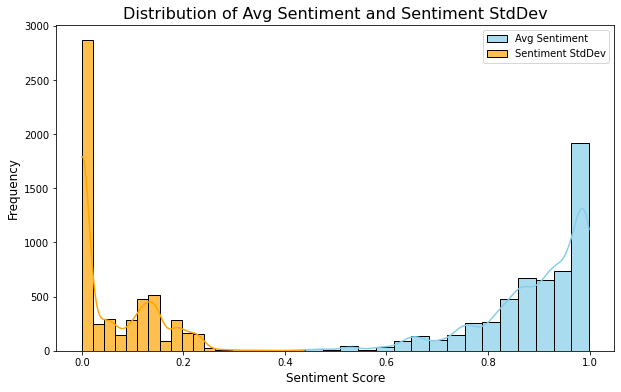

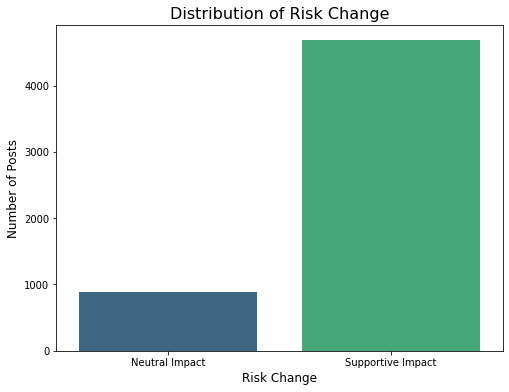

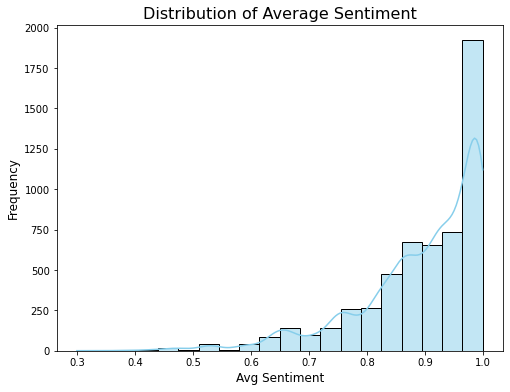

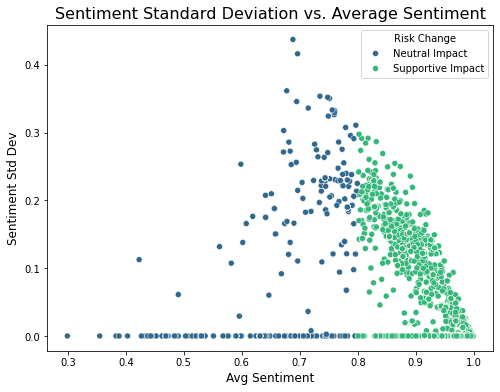

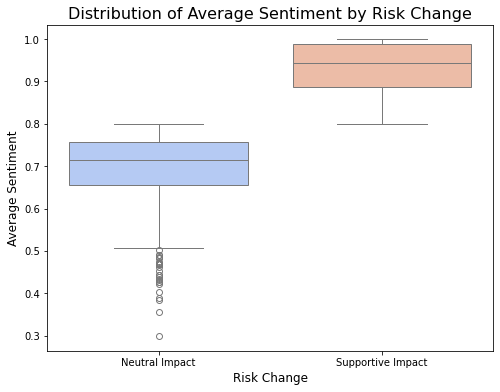

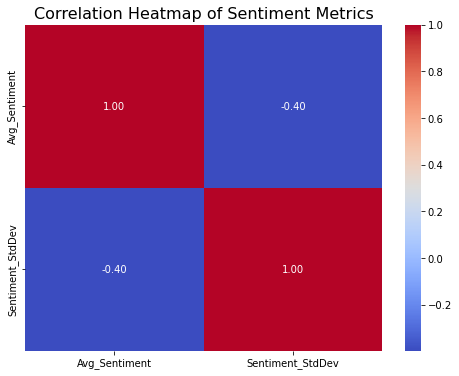

In [59]:
import matplotlib.pyplot as plt
import seaborn as sns

import matplotlib.pyplot as plt
import seaborn as sns

# Plot the distributions of Avg_Sentiment and Sentiment_StdDev
plt.figure(figsize=(10, 6))
sns.histplot(df_posts['Avg_Sentiment'], bins=20, kde=True, color='skyblue', label='Avg Sentiment', alpha=0.7)
sns.histplot(df_posts['Sentiment_StdDev'], bins=20, kde=True, color='orange', label='Sentiment StdDev', alpha=0.7)
plt.title('Distribution of Avg Sentiment and Sentiment StdDev', fontsize=16)
plt.xlabel('Sentiment Score', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.legend()
plt.show()

# Plot the distribution of Risk_Change
plt.figure(figsize=(8, 6))
sns.countplot(data=df_posts, x='Risk_Change', palette='viridis')
plt.title('Distribution of Risk Change', fontsize=16)
plt.xlabel('Risk Change', fontsize=12)
plt.ylabel('Number of Posts', fontsize=12)
plt.show()

# Plot the distribution of Avg_Sentiment
plt.figure(figsize=(8, 6))
sns.histplot(df_posts['Avg_Sentiment'], bins=20, kde=True, color='skyblue')
plt.title('Distribution of Average Sentiment', fontsize=16)
plt.xlabel('Avg Sentiment', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.show()

# Scatter plot of Avg_Sentiment vs. Sentiment_StdDev
plt.figure(figsize=(8, 6))
sns.scatterplot(data=df_posts, x='Avg_Sentiment', y='Sentiment_StdDev', hue='Risk_Change', palette='viridis')
plt.title('Sentiment Standard Deviation vs. Average Sentiment', fontsize=16)
plt.xlabel('Avg Sentiment', fontsize=12)
plt.ylabel('Sentiment Std Dev', fontsize=12)
plt.legend(title='Risk Change')
plt.show()

# Box Plot for Avg_Sentiment by Risk_Change
plt.figure(figsize=(8, 6))
sns.boxplot(data=df_posts, x='Risk_Change', y='Avg_Sentiment', palette='coolwarm')
plt.title('Distribution of Average Sentiment by Risk Change', fontsize=16)
plt.xlabel('Risk Change', fontsize=12)
plt.ylabel('Average Sentiment', fontsize=12)
plt.show()

# Correlation Heatmap
plt.figure(figsize=(8, 6))
correlation_matrix = df_posts[['Avg_Sentiment', 'Sentiment_StdDev']].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap of Sentiment Metrics', fontsize=16)
plt.show()

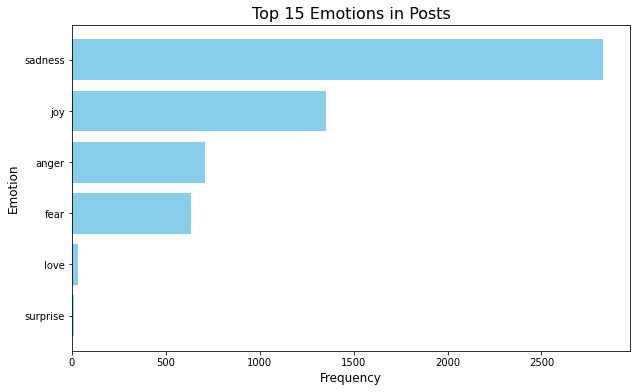

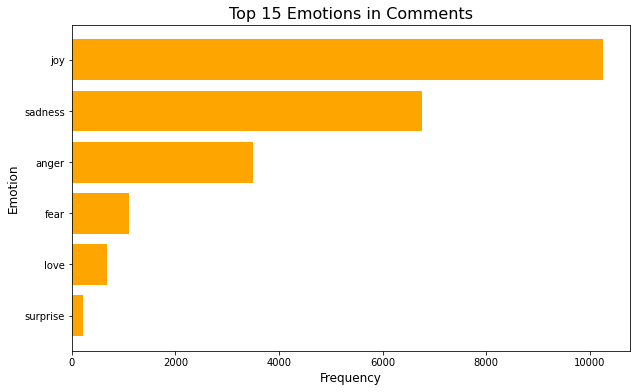

In [56]:
from transformers import pipeline
import pandas as pd
from collections import Counter
import matplotlib.pyplot as plt

# Load the pre-trained BERT emotion detection model
# classifier = pipeline("text-classification", model="bhadresh-savani/bert-base-uncased-emotion")

# Example usage: Concatenate title and body, apply preprocessing
df_posts['Processed_Text'] = df_posts.apply(
    lambda row: preprocess_text(f"{row['Post Title']} {row['Content']}", 
                                lemmatize=True, 
                                correct_spelling=False, 
                                expand_contractions=True),
    axis=1
)

# Function to analyze emotions in text
def detect_emotions(text):
    try:
        result = classifier(text)
        # Extract the top emotion label
        return result[0]['label']
    except Exception as e:
        return "Unknown"  # Default label in case of errors

# Apply emotion detection to posts
df_posts['Emotion'] = df_posts['Processed_Text'].apply(detect_emotions)

# Apply emotion detection to comments
df_comments['Emotion'] = df_comments['Comment Body'].apply(detect_emotions)

### Step 2: Aggregate Emotion Frequencies
# Count the occurrences of each emotion in posts and comments
post_emotions = Counter(df_posts['Emotion'])
comment_emotions = Counter(df_comments['Emotion'])

# Get the top 15 emotions for posts and comments
top_post_emotions = post_emotions.most_common(15)
top_comment_emotions = comment_emotions.most_common(15)

# Convert to DataFrame for visualization
df_top_post_emotions = pd.DataFrame(top_post_emotions, columns=['Emotion', 'Frequency'])
df_top_comment_emotions = pd.DataFrame(top_comment_emotions, columns=['Emotion', 'Frequency'])

### Step 3: Visualization
# Plot top 15 emotions for posts
plt.figure(figsize=(10, 6))
plt.barh(df_top_post_emotions['Emotion'], df_top_post_emotions['Frequency'], color='skyblue')
plt.title('Top 15 Emotions in Posts', fontsize=16)
plt.xlabel('Frequency', fontsize=12)
plt.ylabel('Emotion', fontsize=12)
plt.gca().invert_yaxis()
plt.show()

# Plot top 15 emotions for comments
plt.figure(figsize=(10, 6))
plt.barh(df_top_comment_emotions['Emotion'], df_top_comment_emotions['Frequency'], color='orange')
plt.title('Top 15 Emotions in Comments', fontsize=16)
plt.xlabel('Frequency', fontsize=12)
plt.ylabel('Emotion', fontsize=12)
plt.gca().invert_yaxis()
plt.show()

### Step 4: Save Results
# Save the top emotions and their frequencies to CSV
df_top_post_emotions.to_csv("top_emotions_in_posts.csv", index=False)
df_top_comment_emotions.to_csv("top_emotions_in_comments.csv", index=False)


In [60]:
print(df_posts.columns)


Index(['User', 'Post Title', 'Content', 'Score', 'Comments Count',
       'Upvote Ratio', 'Flair', 'Date', 'Post ID', 'Risk_Change',
       'Avg_Sentiment', 'Sentiment_StdDev', 'Processed_Text', 'Emotion'],
      dtype='object')
The history saving thread hit an unexpected error (OperationalError('unable to open database file')).History will not be written to the database.


In [1]:
# Distribution of Risk Levels
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
sns.countplot(data=df_posts, x='Risk_Level', palette='viridis')
plt.title('Distribution of Risk Levels', fontsize=16)
plt.xlabel('Risk Level', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.show()

# Distribution of Emotions
plt.figure(figsize=(8, 6))
sns.countplot(data=df_posts, x='Emotion', palette='coolwarm', order=df_posts['Emotion'].value_counts().index)
plt.title('Emotion Distribution in Posts', fontsize=16)
plt.xlabel('Emotion', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(rotation=45)
plt.show()


NameError: name 'df_posts' is not defined

<Figure size 576x432 with 0 Axes>